# Выделение групп пользователей на основе поведения в мобильном приложении «Ненужные вещи»

**Цель работы**: Определить целевую аудиторию мобильного приложения «Ненужные вещи» и выдвинуть гипотезы о том, как можно было бы его улучшить с точки зрения пользовательского опыта.

**Основные задачи**:
1. Провести предобработку исходных данных;
2. Исследовать общее поведение пользователей: рассчитать retention rate, время,проведенное в приложении, частоту совершения событий и конверсию в целевое действие - просмотр контактов;
3. Сегментировать пользователей - разделить на группы;
4. Определить, пользователи какой группы склонны чаще возвращаться в мобильное приложение (retention rate) и делать целевое действие (конверсия в целевое действие); 
5. Выделить целевую и смежную группы.
6. Сформировать и проверить статистические гипотезы.

**Источник данных**: Отдел разработчиков.

**Заказчик**: Отдел менеджмента или директор.


**Описание данных**: В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Файл **mobile_dataset.csv** содержит колонки:
- **event.time** — время совершения;
- **event.name** — название события;
- **user.id** — идентификатор пользователя.

*Расшифровки событий*:
- *advert_open* — открытие карточки объявления
- *photos_show* — просмотр фотографий в объявлении
- *tips_show* — пользователь увидел рекомендованные объявления
- *tips_click* — пользователь кликнул по рекомендованному объявлению
- *contacts_show* и *show_contacts* — пользователь нажал на кнопку `посмотреть номер телефона` на карточке объявления
- *contacts_call* — пользователь позвонил по номеру телефона на карточке объявления
- *map* — пользователь открыл карту размещенных объявлений
- *search_1* — *search_7* — разные события, связанные с поиском по сайту
- *favorites_add* — добавление объявления в избранное

Файл  **mobile_sources.csv** содержит колонки:
- **userId** — идентификатор пользователя
- **source** — источник, с которого пользователь установил приложение

## Загрузка, обзор и предобработка данных 

### Загрузим данные из файла в датафрейм

In [1]:
# Импортируем все необходимые библиотеки:
import pandas as pd
from datetime import  datetime, timedelta
import seaborn as sns
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math as mth
import warnings

# Вводим конфигурацию,улучшающую четкость картинок во всем проекте:
%config InlineBackend.figure_format = 'retina'
# Добавим код, чтобы текст в ячейке отражался полностью вне зависимости от длины:
pd.set_option('display.max_colwidth', None)
# Для игнорирования предупрждений вводим специальный метод:
warnings.filterwarnings("ignore")

In [2]:
# Считываем данные из csv-файла в датафрейм:
try:
    mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
    mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
except:
    mobile_sourсes = pd.read_csv('/datasets/mobile_soures.csv')
    mobile_dataset = pd.read_csv('/datasets/mobile_dataset.csv')

### Изучим общую информацию о полученном датафрейме

In [3]:
# Выводим первые 5 строк датафрейфмов на экран с помощью методов display() и head():
display(mobile_sourсes.head())
display(mobile_dataset.head())


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [4]:
# Выводим основную информацию о каждом датафрейме с помощью метода info():
display(mobile_sourсes.info())
display(mobile_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

Названия колонок в датафреймах необходимо будет привести к хорошему стилю, а тип данных столбца `event.time`, содержащего дату и время, к типу данных datetime.

### Подготовим данные к анализу

#### Проверим, есть ли про пропуски в данных

In [5]:
# Ищем пропуски в датафреймах методом isna() и sum(): 
mobile_sourсes.isna().sum().sort_values(ascending=False)

userId    0
source    0
dtype: int64

In [6]:
mobile_dataset.isna().sum().sort_values(ascending=False)

event.time    0
event.name    0
user.id       0
dtype: int64

В исследуемых данных отсутствуют пропущенные значения.

#### Исследуем данные на наличие явных дубликатов

In [7]:
# Проверяем датафреймы на наличие явных дубликатов методом duplicated() и считаем их количество методом sum():
print('Количество дубликатов в датафрейме mobile_sourсes:', mobile_sourсes.duplicated().sum())
print('Количество дубликатов в датафрейме mobile_dataset:', mobile_dataset.duplicated().sum())

Количество дубликатов в датафрейме mobile_sourсes: 0
Количество дубликатов в датафрейме mobile_dataset: 0


Явных дубликатов не обнаружено.

#### Переименуем колонки

In [8]:
# Переименуем колонку в в датафрейме mobile_sourсes методом rename():
mobile_sourсes.rename(columns={'userId': 'user_id'}, inplace=True)
mobile_sourсes

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google
...,...,...
4288,b86fe56e-f2de-4f8a-b192-cd89a37ecd41,yandex
4289,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,yandex
4290,437a4cd4-9ba9-457f-8614-d142bc48fbeb,yandex
4291,c10055f0-0b47-477a-869e-d391b31fdf8f,yandex


In [9]:
# Для переименования колонок в датафрейме mobile_dataset используем подход с использованием list comprehensions:
mobile_dataset.columns = [x.lower().replace('.', '_') for x in mobile_dataset.columns.values]
mobile_dataset

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9


#### Исследуем данные на наличие неявных дубликатов

In [10]:
# Выведем уникальные значения колонок датафреймов, где могут быть дубликат:
print('Уникальные значения колонки с источником установки приложения:', mobile_sourсes['source'].unique())
print()
print('Уникальные значения колонки с названием события:', mobile_dataset['event_name'].unique())

Уникальные значения колонки с источником установки приложения: ['other' 'yandex' 'google']

Уникальные значения колонки с названием события: ['advert_open' 'tips_show' 'map' 'contacts_show' 'search_4' 'search_5'
 'tips_click' 'photos_show' 'search_1' 'search_2' 'search_3'
 'favorites_add' 'contacts_call' 'search_6' 'search_7' 'show_contacts']


Можно сделать вывод, что такие названия событий, как `contacts_show` и `show_contacts`, можно считать одинаковыми, а события, связанные с поиском в рамках нашего исследования можно объединить в одно событие `search`.  

In [11]:
# Методом replace() заменим значение 'show_contacts' в колонке'event_name' на 'contacts_show':
mobile_dataset['event_name'].replace('show_contacts', 'contacts_show', inplace=True)

In [12]:
# Методом replace() с параметром to_replace() заменим все события, связанные с поиском, на 'search':
mobile_dataset['event_name'].replace(to_replace ='search_[1234567]', value = 'search', regex = True, inplace=True)

#### Приведем данные в колонках к нужному типу

In [13]:
# Преобразуем данные о времени методом to_datetime():
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])

#### Объединим датафреймы

In [14]:
# Объединим таблицы методом merge():
data = mobile_dataset.merge(mobile_sourсes, on='user_id', how='left')

*Выводы по разделу 1:*

- Пропуски и явные дубликаты в данных отсутствуют; 
- Выявленные неявные дубликаты в названиях события просмотр контактов переименованы, а все события, связанные с поиском, объединены в одно;
- Названия столбцов таблиц приведены к "хорошему" стилю;
- Столбец с датой и временем события переведен в формат datetime;
- Таблицы с данными объединены в один датафрейм.


## Исследование общего поведения пользователей

### Создадим профили пользователей

In [15]:
#Создадим функцию для создания профилей get_profiles():
def get_profiles(sessions):

    # сортируем сессии по ID пользователя и дате первого посещения
    # группируем по ID и находим первые значения session_start и channel
    # столбец с временем первого посещения назовём first_ts
    profiles = (
        sessions.sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time': 'first', 'source': 'first'})
        .rename(columns={'event_time': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    # эти данные понадобятся для когортного анализа
    profiles['dt'] = profiles['first_ts'].dt.date
    
    return profiles 

In [16]:
# Получим профили пользователей по нашим данным:
profiles = get_profiles(data)
profiles.head()

,user_id,first_ts,source,dt
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,yandex,2019-10-19
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,yandex,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,google,2019-10-18
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,yandex,2019-10-25


### Рассчитаем retention rate 

In [17]:
# Определим минимальную дату привлечения пользователей
min_analysis_date = profiles['dt'].min()
print('Минимальная дата привлечения пользователей:', min_analysis_date)

Минимальная дата привлечения пользователей: 2019-10-07


In [18]:
# Определим максимальную дату привлечения пользователей
max_analysis_date = profiles['dt'].max()
print('Максимальная дата привлечения пользователей:', max_analysis_date)

Максимальная дата привлечения пользователей: 2019-11-03


Таким образом, мы располагаем данными с 7 октября по 3 ноября 2019 года.

 Для определения полноты данных за этот период построим гистограмму.

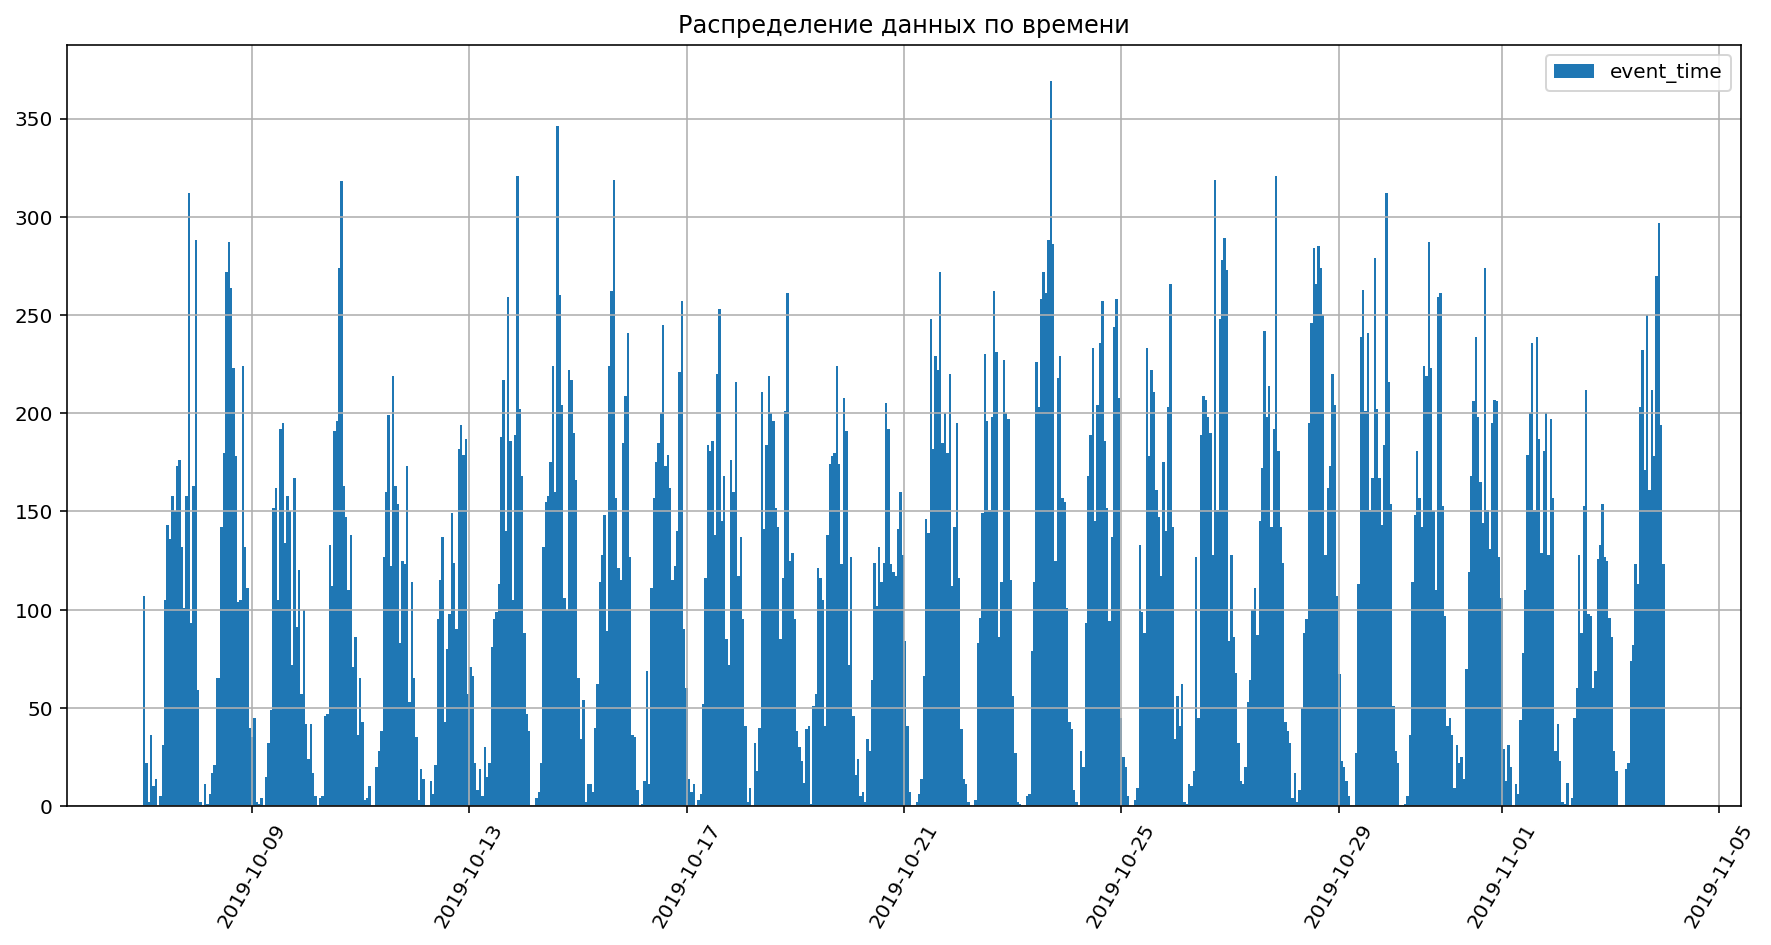

In [19]:
# Построим гистограмму по дате и времени:
data['event_time'].hist(bins=27*24, figsize = (15,7),legend=True)
plt.xticks(rotation=60)
plt.title('Распределение данных по времени');

Таким образом, данные за рассматриваемый период достаточно полные.

In [20]:
# Создадим функцию retention() для расчета удержания:

def retention(data):
    # присоединяем result_raw к профилям по столбцу user_id
    result_raw = profiles.merge(
    data[['user_id', 'event_time']], on='user_id', how='left'
    )

    # вычисляем лайфтайм каждой сессии в днях
    result_raw['lifetime'] = (
    result_raw['event_time'] - result_raw['first_ts']
    ).dt.days

    # строим таблицу удержания
    result_grouped = result_raw.pivot_table(
    index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )

    # вычисляем размеры когорт
    cohort_sizes = (
    result_raw.groupby('dt')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
    )

    # объединяем размеры когорт и таблицу удержания
    result_grouped = cohort_sizes.merge(
    result_grouped, on='dt', how='left'
    ).fillna(0)

    # делим данные таблицы удержания на размеры когорт
    result_grouped = result_grouped.div(
    result_grouped['cohort_size'], axis=0
    ).drop(columns=['cohort_size'])
    
    # строим тепловую карту удержания пользователей
    plt.figure(figsize=(20, 20))  # задаём размер графика
    sns.heatmap(
            result_grouped.drop(columns=[0]),  # удаляем размеры когорт
            annot=True,  # включаем подписи
            fmt='.1%',  # переводим значения в проценты
            )
    plt.title('Тепловая карта удержания')  # название графика
    plt.ylabel('Дата привлечения')
    plt.xlabel('Лайфтайм')
    plt.show()
    

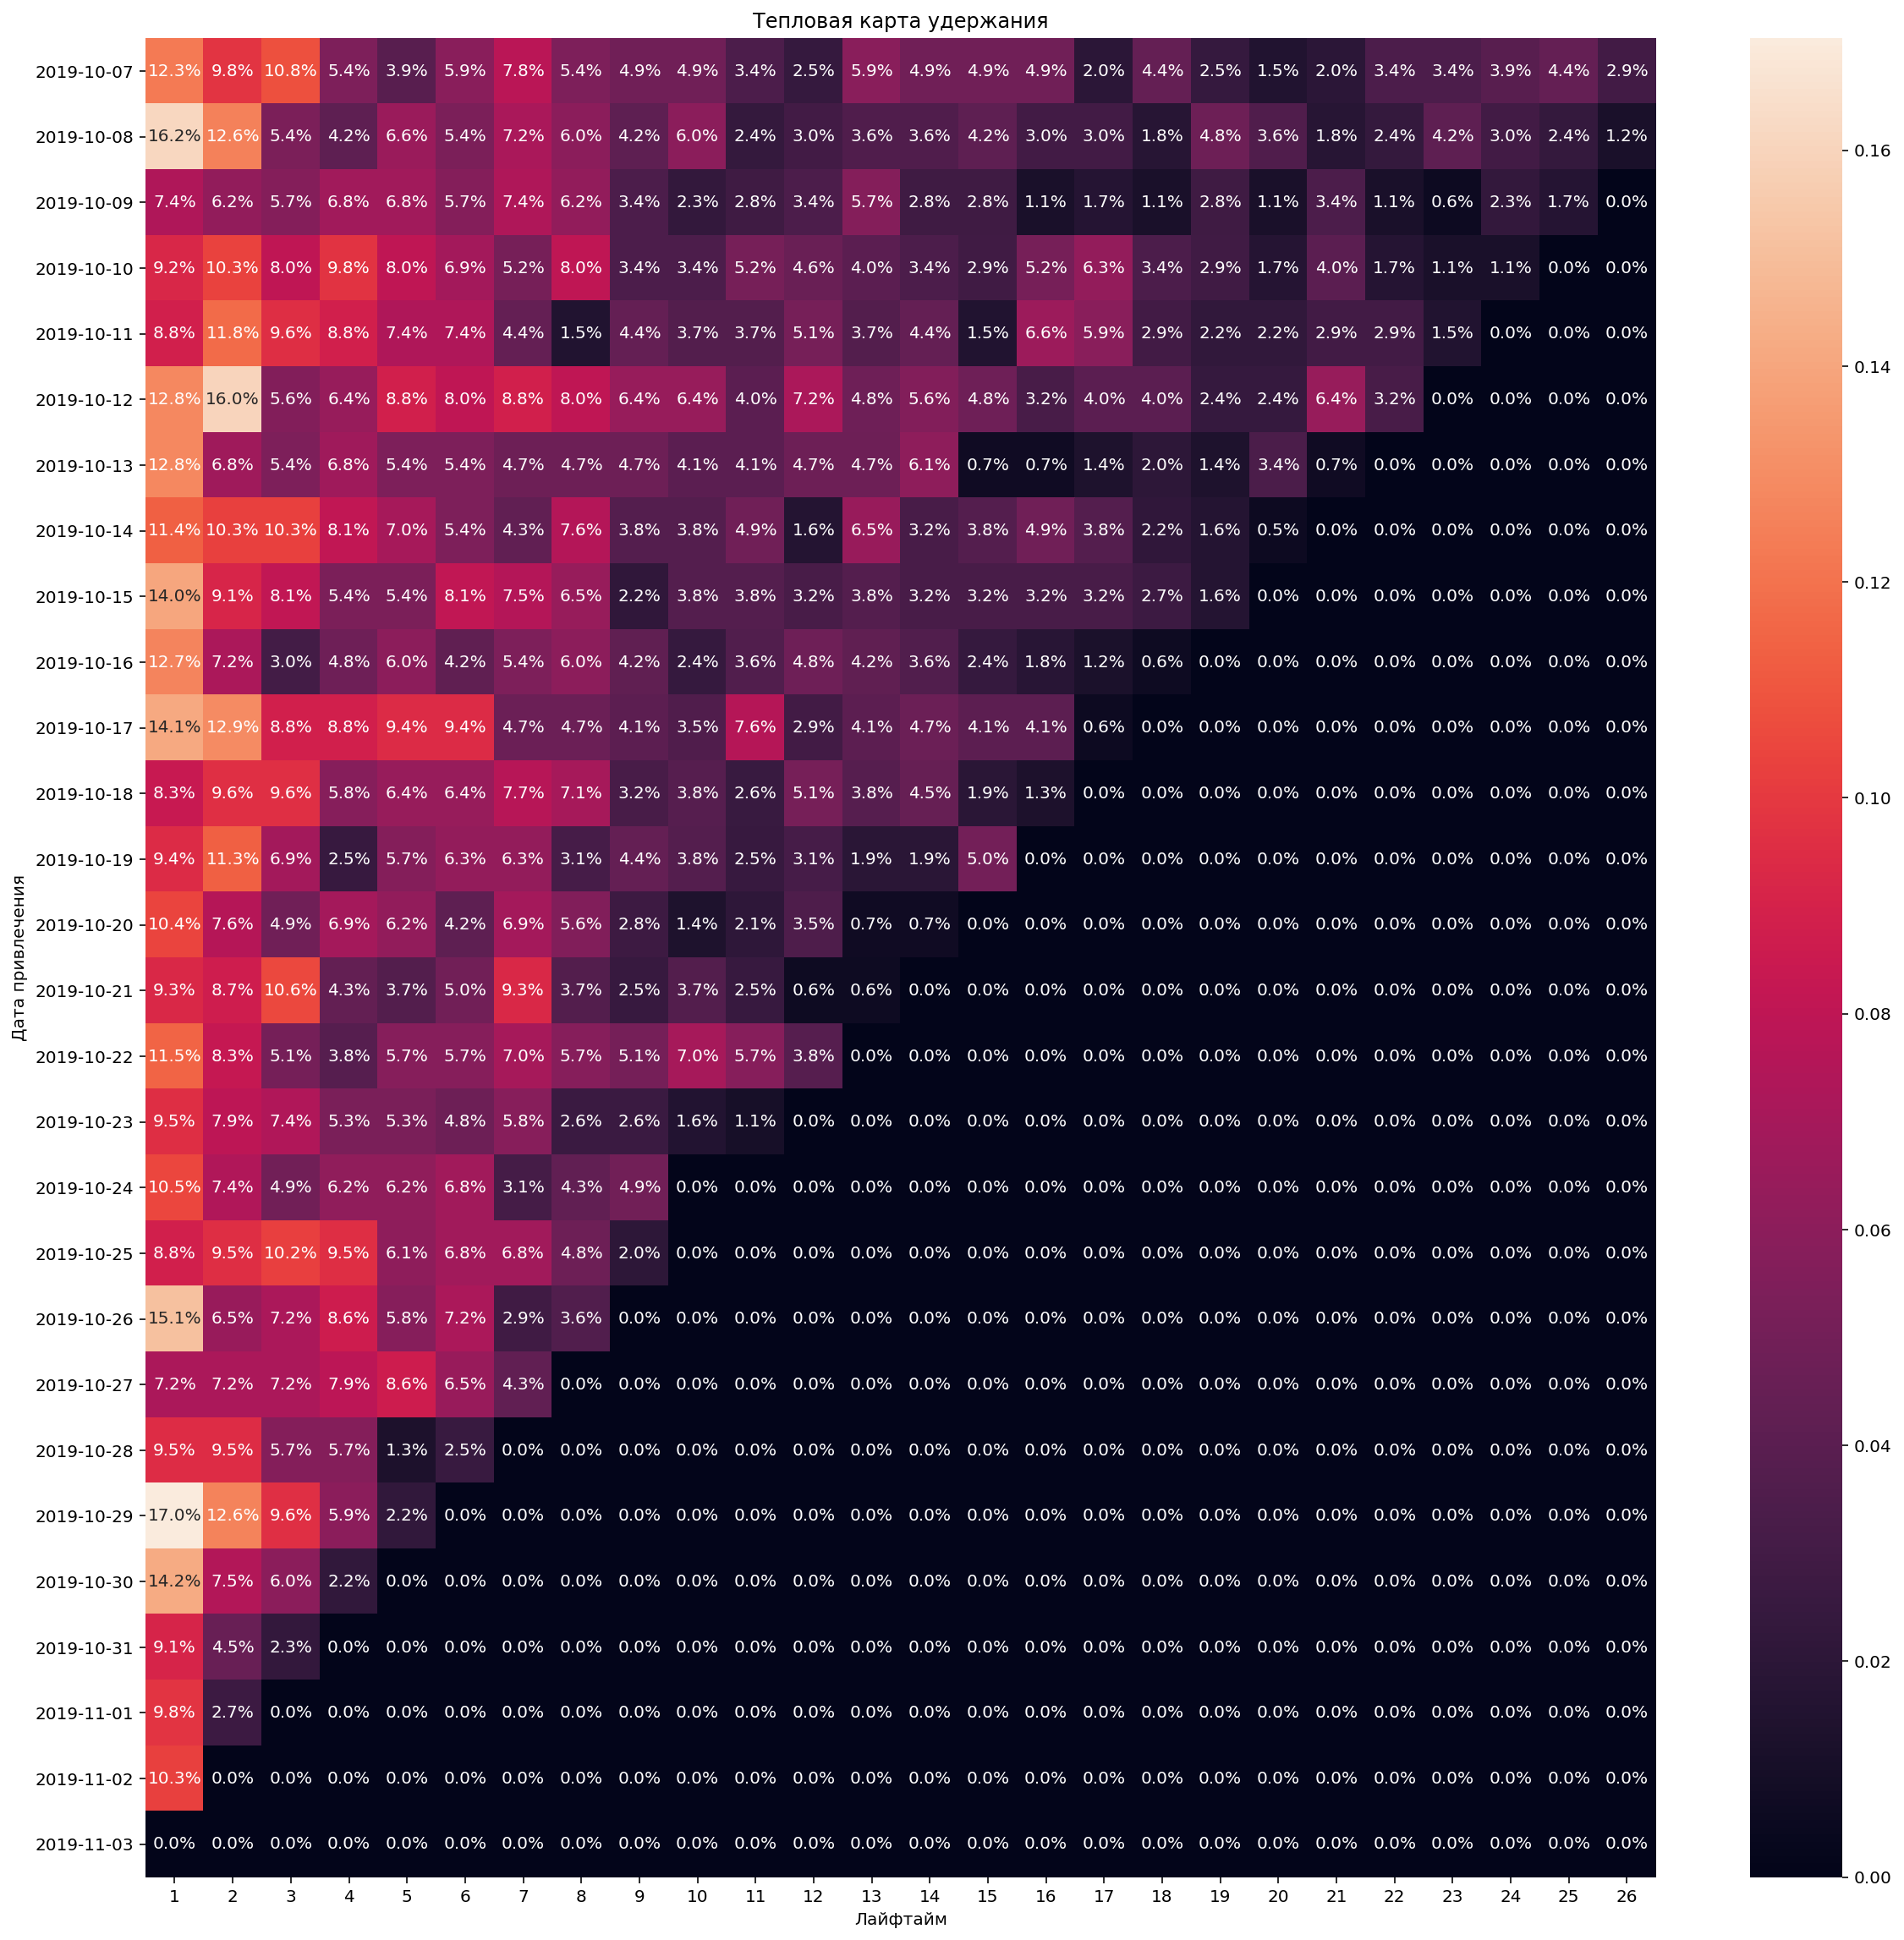

In [21]:
# Передадим функции retention() объединенный датафрейм data: 
retention(data)

Лучший процент удержания в первые дни использования приложения: наибольший - у пользователей привлеченных 29 октября (17.0 % в первый, 12.6 % во второй и 9.6 % в третий день), достаточно близкий процент удержания в первые два дня использования приложения и у пользователей, привлеченных 8 октября - 16.2 % и 12.6 % соответственно, однако уже на третий день удержание данных пользователей падает до 5.4 %. Достаточно высокий процент удержания в первый день использования приложения у пользователей, привлеченных 26 октября (15,1 %), 15, 17 и 30 октября - около 14 % и 12, 13, 16 октября - чуть менее 13 %. При этом 12 и 26 октября - это субботы.

В целом, лучший процент удержания пользоваталей наблюдается в первые дни использования приложения, а с увеличением лайфтайма наблюдается снижение процента удержания, в то же время рост процента удержания после его снижения независимо от даты привлечения может быть связан с возвращением пользователей в приложение после их отсутствия в течение суток и более, либо же с выходными днями.

### Узнаем время, проведенное в приложении

Выделяем сессии относительно тайм-аута. Если между событиями время больше `20 мин`, то будем их относить к разным сессиям. Среднее время сессии пользователей мобильных приложений с каждым годом увеличивается и в 2022 году составляет уже около 19-20 мин (по данным Adjust). Однако, наши данные представлены за 2019 год, в котором, по данным той же компании - средняя продолжительность сессии составляла `10-11 мин`. Если же выбор данного тай-аута позволит добиться близкого значения продолжительности сессии к представленным в анализе значениям, остановимся на нем, в ином случае будем его уменьшать или увеличивать до достижения необходимой средней продолжительности сессии.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__


По дефолту во всяких гугл аналитика, Яндекс метрика тайм аут сессии 30 мин. А так, зависит от степени конфиденциальности приложения. чем меньше, тем безопаснее


In [22]:
# Сортируем датафрейм по датасет по user_id и event_time и сравниваем разницу по времени со значением 20 мин, если значение 
# больше, то получим 1, которые складываем методом cumsum(), выделяя новые сессии
g = (data.sort_values(['user_id', 'event_time']).groupby('user_id')['event_time'].diff() > pd.Timedelta('20Min')).cumsum()
# Создаем столбец с уникальными идентификаторами сессий
data['session_id'] = data.groupby(['user_id', g], sort=False).ngroup() + 1
data

,event_time,event_name,user_id,source,session_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,1
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,1
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,1
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2
...,...,...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,10958
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,10958
74194,2019-11-03 23:56:57.041825,search,20850c8f-4135-4059-b13b-198d3ac59902,google,10975
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,10958


Всего получилось 10958 уникальных сессий.

In [23]:
# Рассчитаем продолжительность сессий пользователей
data['session_duration'] = data.groupby(['session_id'])['event_time'].max() - data.groupby(['session_id'])['event_time'].min()
data.head()

,event_time,event_name,user_id,source,session_id,session_duration
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,1,NaT
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,1,0 days 00:18:42.485791
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2,0 days 00:41:37.869753
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,1,0 days 00:28:14.998934
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2,0 days 00:00:03.236810


In [24]:
# Посмотрим, как распределены значения в полученной колонке методом describe():
data['session_duration'].describe()

count                        10975
mean     0 days 00:10:48.680013362
std      0 days 00:16:06.450581315
min                0 days 00:00:00
25%         0 days 00:00:11.937717
50%         0 days 00:04:55.340814
75%      0 days 00:14:57.538053500
max         0 days 03:53:38.911775
Name: session_duration, dtype: object

Средняя продолжительность сессии при тайм-ауте 20 мин равна 10 мин 48 сек. Данное значение достаточно близко к средней продолжительности сессии пользователей в мобильных приложениях в 2019 году. Однако, нельзя полностью исключать тот факт, что в анализе Adjust учитывались и выбросы. В любом случае, в нашем исследовании мы будем брать `медианное значение сессии - 4 мин 55 сек`, так как в данных имеются выбросы: макисмальное значение сессии - более 3 дней, и минимальное - 0 дней 00:00:00. 

Таким образом, медианное время, проведенное пользователем в приложении - `4 мин 55 сек`.  

<div class="alert alert-block alert-warning">📝
    

__Комментарий от тимлида №1__


Здесь еще бы посмотреть что за события были в нулевой сессии. Возможно пользователь просто открыл приложение, появилась рекомендация `tips_show` и на этом его активность закончилась, тогда это не программный сбой.
</div>

### Опеределим частоту совершения событий

In [25]:
# Посмотрим, какие события есть в логах, отсортируем их по частоте:
(data.groupby('event_name').agg({'event_name':'count'}).rename(columns={'event_name': 'Количество в логе'})
      .sort_values(by='Количество в логе', ascending=False))

,Количество в логе
event_name,
tips_show,40055
photos_show,10012
search,6784
advert_open,6164
contacts_show,4529
map,3881
favorites_add,1417
tips_click,814
contacts_call,541


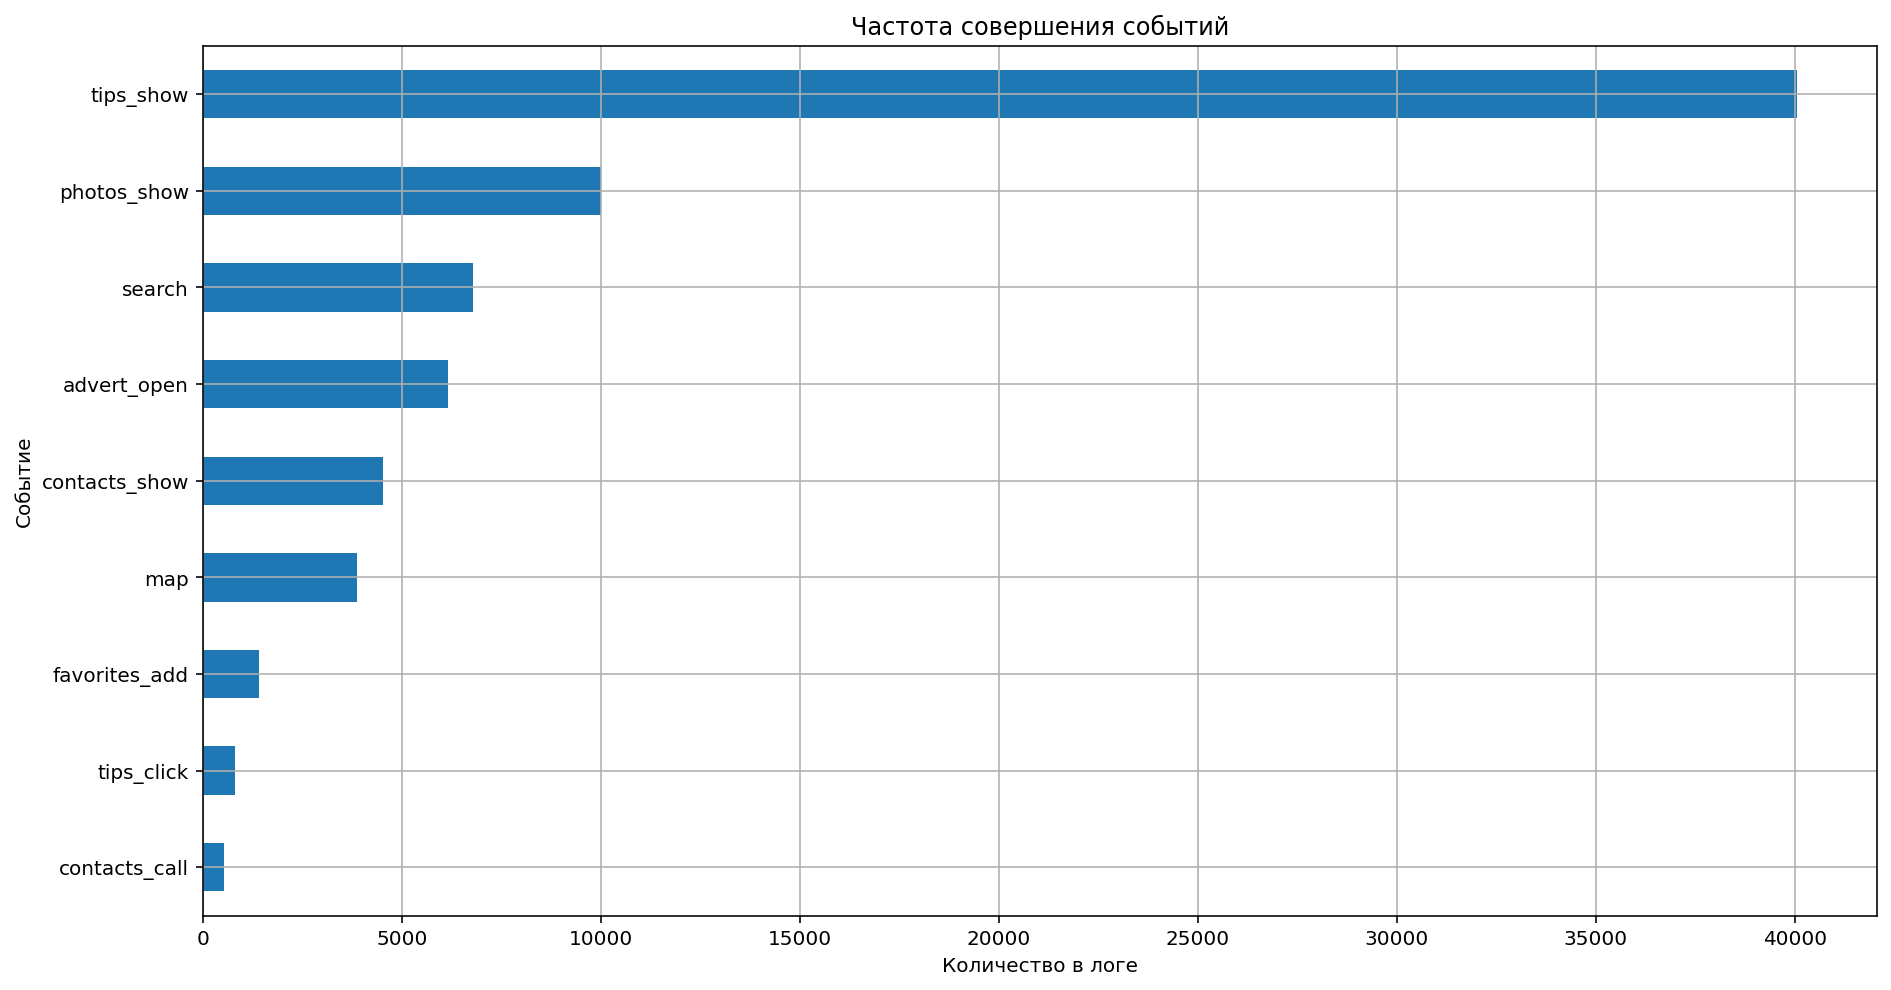

In [26]:
# Построим график вида 'barh':
(data.groupby('event_name').agg({'event_name':'count'}).rename(columns={'event_name': 'Количество в логе'})
      .sort_values(by='Количество в логе').plot(kind='barh', grid=True,legend=False, figsize=(15, 8))
);
plt.xlabel("Количество в логе")
plt.ylabel("Событие")
plt.title('Частота совершения событий');

Чаще всего пользователи видели рекомендованные объявления (около 40055), практически в 4 раза реже просматривали фотографии в объявлении, ещё реже занимались поиском по сайту и открывали карточки объявления, а на кнопку `посмотреть номер телефона` нажимали не более 4529 раз.  Самое непопулярное событие в логе - звонок по номеру телефона (не более 541 раза).

Теперь посмотрим, как данные события распределены по времени.

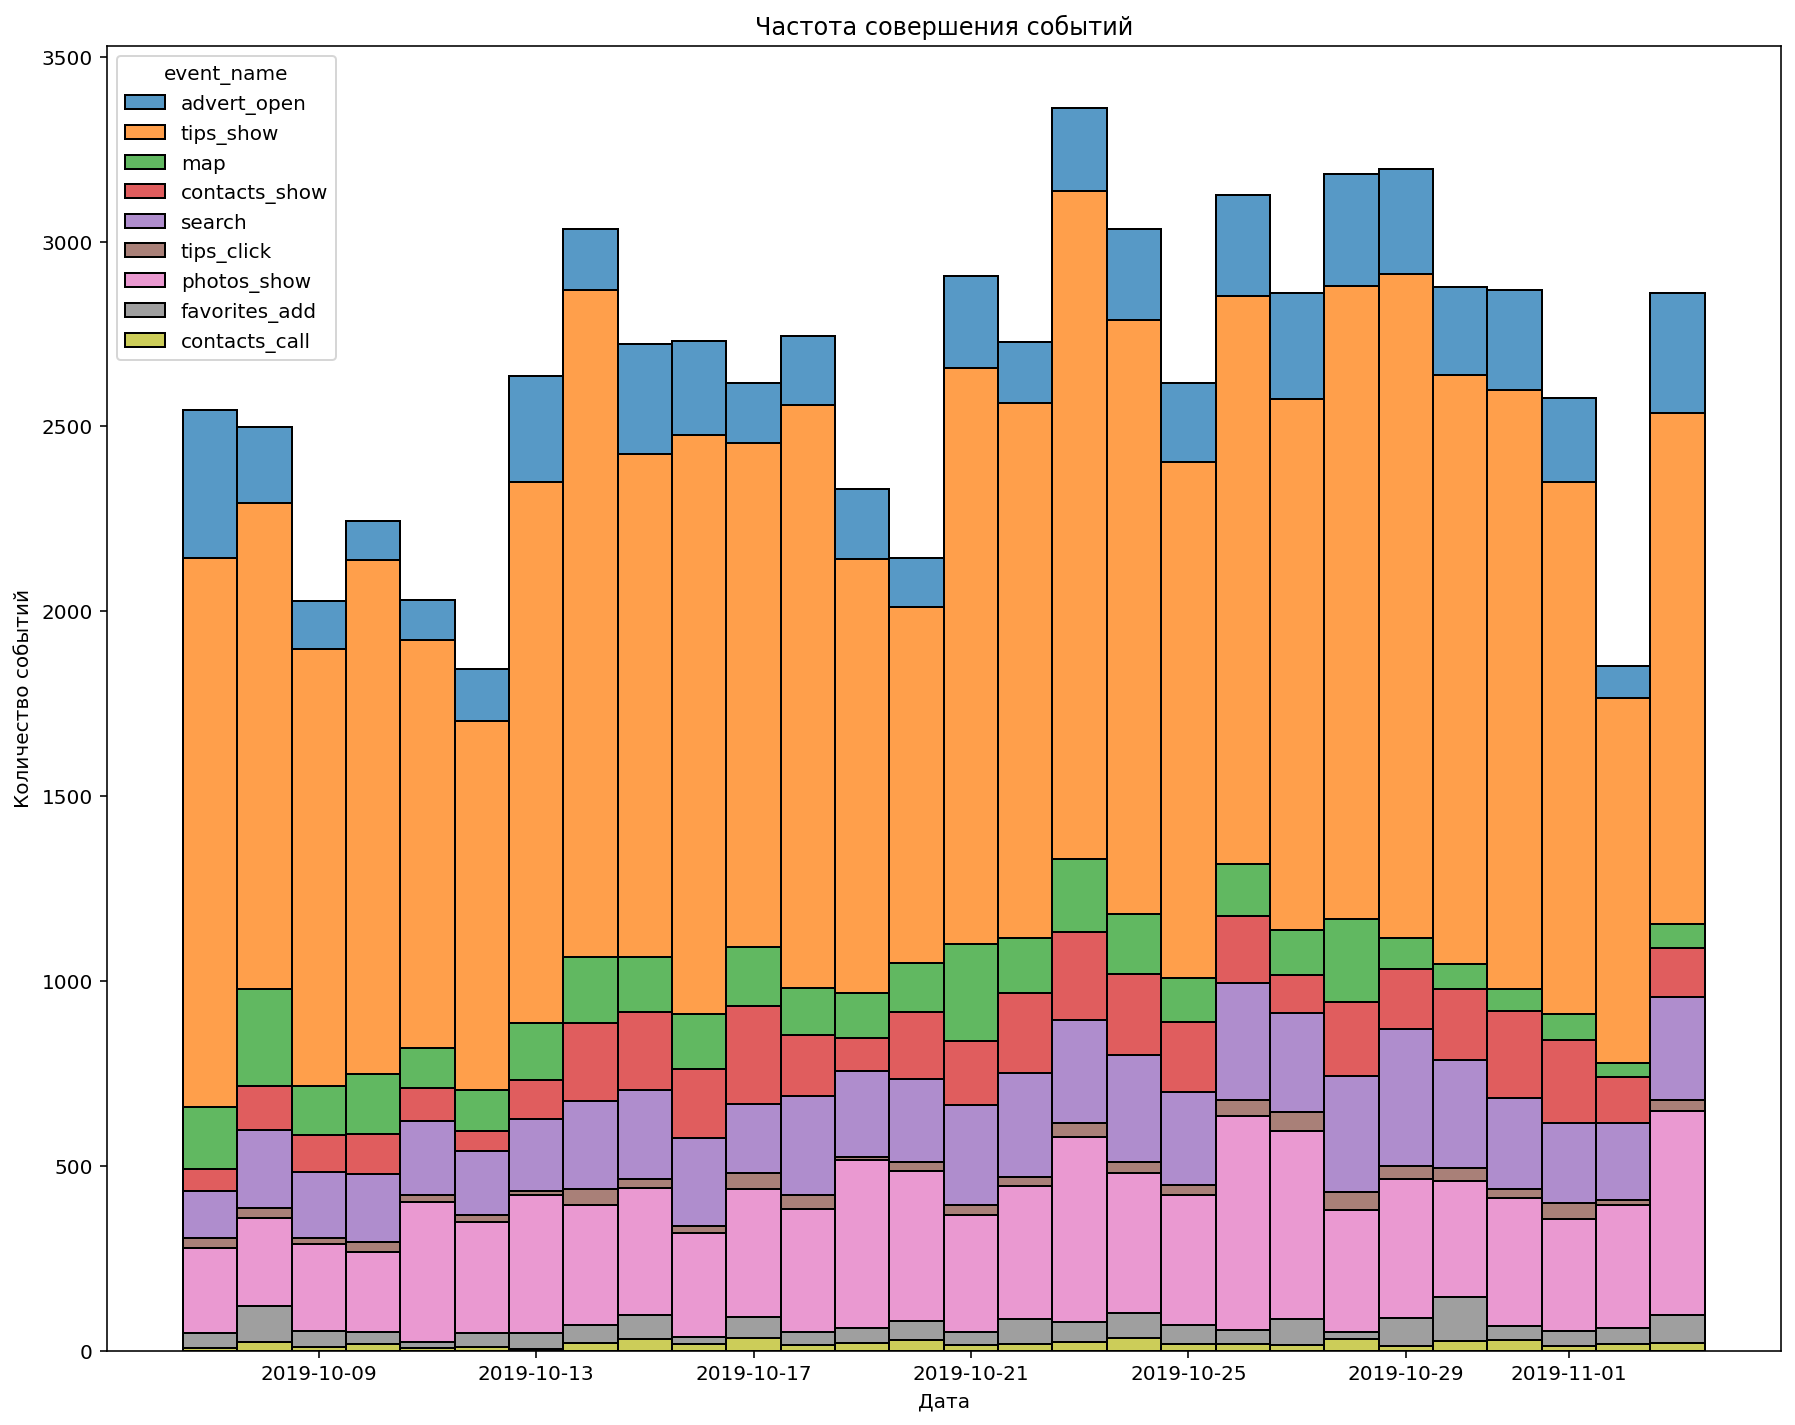

In [27]:
plt.figure(figsize=(15,12))
sns.histplot(data=data, x=data["event_time"].dt.date, hue='event_name', multiple="stack")
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.title('Частота совершения событий');

<div class="alert alert-block alert-danger">✍
    

__Комментарий от тимлида №1__

Легенда перекрывает график. Поправь, пожалуйста, этот момент по проекту

<div class="alert alert-info"> <b>Комментарии студента:</b> Поправил </div>

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №2__

Супер, старайся, пожалуйста, придерживаться этой стратегии в дальнейших проектах =)

Наибольшее число событий в сутки было зафиксировано 23 октября в среду и 29 октября во вторник. Также достатчно много событий наблюдается по понедельникам 7, 14, 21 и 28 октября и во вторник 29 октября. В субботы 12 октября и 2 ноября произошло меньше всего событий. В связи с этим и по характеру зависимости частоты совершения событий в зависимости событий (снижение в течение недели), можно предположить, что в будние дни пользователи в приложении более активны. 

Для проверки этого утверждения посмотрим, как распределены события по будням и по выходным дням в целом.

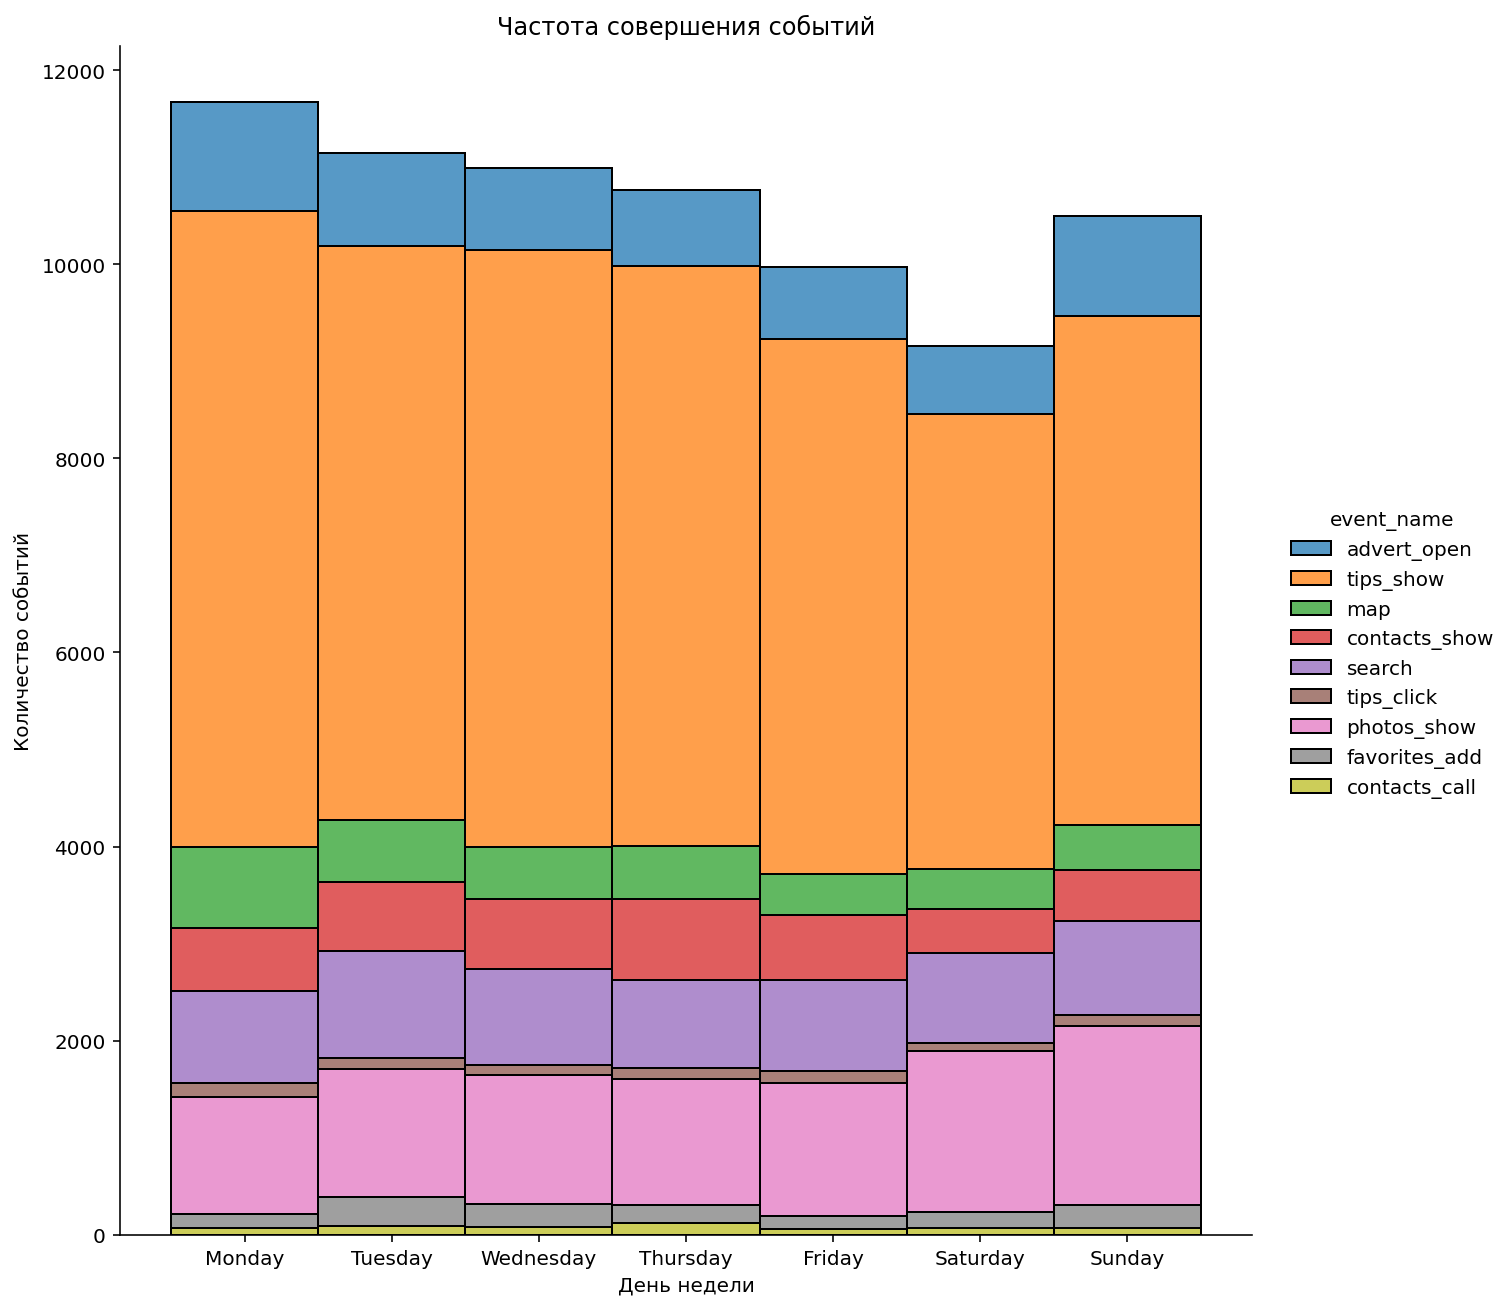

In [28]:
# Построим гистрограмму, отражающую частоту событий по дням недели

sns.displot(data=data, x=data['event_time'].dt.day_name(), height=9, legend=True, hue='event_name', multiple="stack")
plt.xlabel("День недели")
plt.ylabel("Количество событий");
plt.title('Частота совершения событий');

Больше всего событий произошло в понедельник, в течение недели их количество постепенно снижалось, достигнув минимального значения в субботу. После чего в воскресенье снова наблюдался резкий рост активности пользователей. В то же время в выходные дни наблюдалось некоторое снижение числа просмотров контактов и увеличение числа просмотров фотографий. Снижение пользовательской активности при приближении к пятнице и субботе можно объяснить нежеланием большинства пользователей проводить сделки и после этого забирать купленные ими вещи в выходные дни, также в более активное использование приложения в рабочие дни может быть связано и с поездками пользователей в общественном траспорте на работу и домой, а рост активности пользователей в воскресенье, вероятно, связан с их подготовкой к проведению сделок в будние дни.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

Во многих продуктах в выходные наблюдается спад активности. Все стараются максимально использовать это время для отдыха, семьи и т.д. Так что вполне логичные результаты.

### Рассчитаем конверсию в просмотры контактов

In [29]:
# Посмотрим, сколько всего уникальных пользоваталей в логе
print ('Всего уникальных пользователей:', data['user_id'].nunique())

Всего уникальных пользователей: 4293


In [30]:
# Найдем количество пользователей, которые совершили каждое из событий:
event_user = data.groupby('event_name').agg({'user_id': 'nunique'})
event_user.columns = ['Число пользователей']
# и посчитаем долю, пользотвателей, которые хоть раз совершили событие:
event_user['Конверсия, %'] = round(event_user['Число пользователей']*100 / data['user_id'].nunique())
event_user = event_user.sort_values(by='Число пользователей', ascending=False).reset_index()
event_user.rename(columns={"event_name": "Событие"})

,Событие,Число пользователей,"Конверсия, %"
0,tips_show,2801,65.0
1,search,1666,39.0
2,map,1456,34.0
3,photos_show,1095,26.0
4,contacts_show,981,23.0
5,advert_open,751,17.0
6,favorites_add,351,8.0
7,tips_click,322,8.0
8,contacts_call,213,5.0


65 % пользователей от общего количества увидели рекомендованные объявления, 39 % - проводили поиск по сайту, 34 % - смотрели карту размещенных объявлений, 26 % смотрели фотографии объявлений и 23 % посмотрели  номер телефона. Только 5 % пользователей позвонили по номеру телефона в объявлении.

Таким образом, конверсия пользователей,нажавших на кнопку `посмотреть номер телефона` на карточке объявления от общего числа пользователей составляет `23 %`.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

Конверсия рассчитана корректно

Выводу к разделу 2:

- Данные, представленные за период с 7 октября по 3 ноября 2019 года, достаточно полные;
- Самый высокий процент удержания наблюдается в первые дни использования приложения. Так, у пользователей, привлеченных 26 и 29 октября в первый и второй лайфтайм он составил 17 и 12,6 % и 16 и 12,6 %, соответственно. С увеличением лайфтайма наблюдается снижение удержания пользователей, а скачки процента удержания могут быть связаны с возвращением пользователей в приложение спустя несколько дней;
- Выделены сессии относительно тай-аута, равного 20 мин. Всего получилось 10958 уникальных сессий. Медианная продолжительность сессии пользователя в приложении составила 4 мин 55 сек;
- Самое часто совершаемое событие – увидеть рекомендованное объявление (около 40 000 просмотров).  Значительно реже пользователи кликают на фотографии в объявлении (10 000), ещё реже открывают карточки объявления (6164) и просматривают номер телефона (4529).  Реже всего пользователи звонили по номеру в объявлении - 541 раз);
- Больше всего событий в сутки произошло в среду 29 октября и во вторник 23 октября, меньше всего в субботы – 12 октября и 2 ноября. В целом, в течение недели с понедельника по субботу наблюдается снижение пользовательской активности, а в воскресенье она снова возрастает. Вероятно, это связано с нежеланием большинства пользователей проводить сделки и забирать товар в выходные дни, а рост в воскресенье – с подготовкой к проведению сделок в будние дни. В тоже время не стоит исключать, что активность  пользователей в будние дни может быть связана и с использованием приложения  по дороге на/с работы, например, в общественном транспорте в крупных городах;
- Всего в датафрейме 4293 уникальных пользователя. Конверсия пользователей в просмотр номера телефона от общего числа пользователей составила 23 %. Чаще всего пользователи видели рекомендованные объявления (65 % пользователей) и пользовались поиском (39 %), реже всего - добавляли объявления в избранное (8 %), кликали по рекомендованному объявлению (8 %) и  звонили по номер телефона в карточке (5 %).   

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

Грамотно проведенный этап. Все пункты рассмотрены. Молодец!
</div>

## Сегментация пользователей 

### Разделим пользователей на группы по источнику привлечения 

In [31]:
# Посмотрим, какие источники привлечения имеются в данных 
data['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

В данных три источника привлечения: `Яндекс`, `Гугл` и `Другие источники`.

Таким образом, получилось 3 группы пользователей:
- Пользователи, загрузившие приложение через `Яндекс`;
- Пользователи, загрузившие приложение через `Гугл`;
- Пользователи, загрузившие приложение через `Другие источники`.

Такая сегментация поможет заказчику понять в рекламу приложения на каком из этих каналов стоит вкладывать средства в первую очередь.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

Очень хорошо, что обосновал свой выбор сегментации
</div>

In [32]:
# Посмотрим на распределение пользователей по этим источникам:

(data.groupby('source').agg({'user_id':'nunique'}).rename(columns={'user_id': 'Количество пользователей'})
      .sort_values(by='Количество пользователей', ascending=False))

,Количество пользователей
source,
yandex,1934
other,1230
google,1129


Больше всего пользователей из лога установило приложение через Яндекс (1934 человека), меньше всего -  через Гугл (1129). В целом, распределение пользователей между группами достаточное для дальнейшего анализа (меньшая по количеству пользователей группа значительно превышает минимально допустимый порог в 10 % от количества пользователей большей группы).

### Определим, пользователи какой группы склонны чаще возвращаться в мобильное приложение (retention rate)

In [33]:
# Выделим данные с пользователями, загрузившими приложение через Яндекс
yandex = data.loc[data['source'] == 'yandex']
# Получим профили пользователей, загрузивших приложение через Яндекс
profiles = get_profiles(yandex)

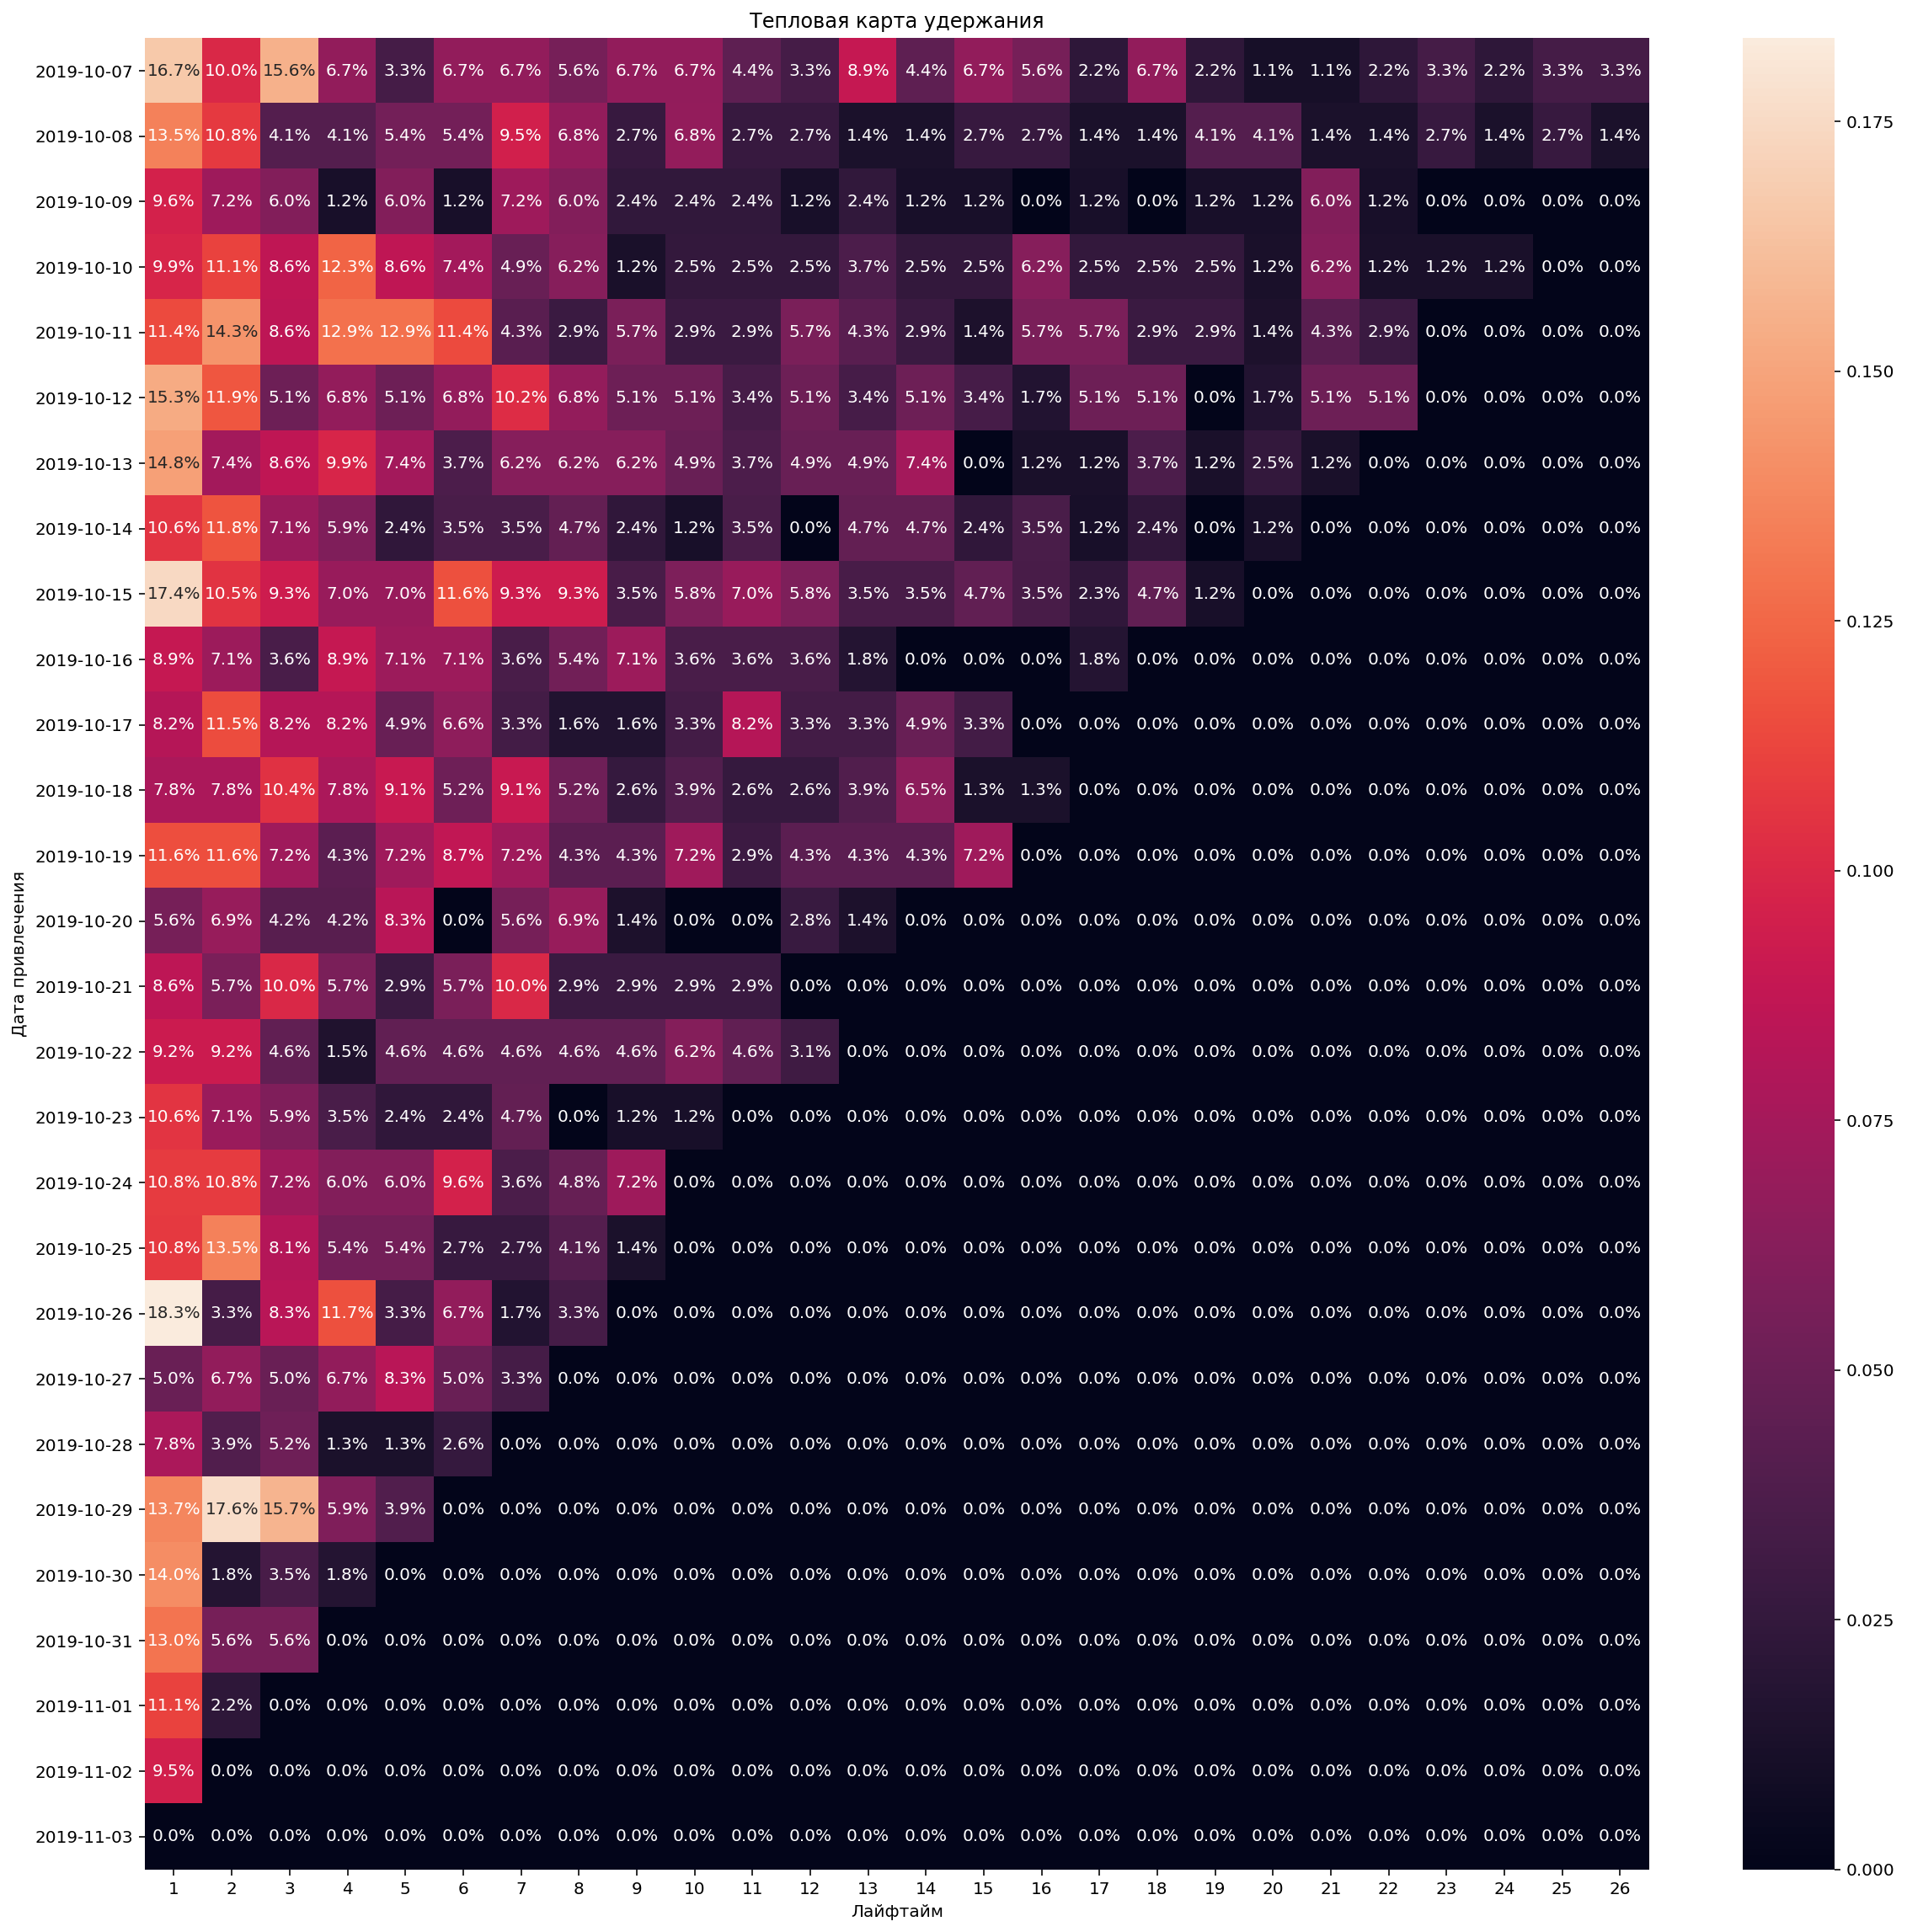

In [34]:
# Передадим функции retention() таблицу с данными о пользователях, загрузивших приложение через Яндекс
retention(yandex)

Пользователи, привлеченные через Яндекс, демонстрируют достаточно высокий процент удержания в первые дни использования приложения: так, например, удержание пользователей, привлеченных 15 октября и 26 октября достигает 17,4 и 18,3 % соответственно, неплохое удержание пользователей можно наблюдать и на второй день использования приложения (до 12-14 %), за 5 дней лайфтайма удержание не достигает нулевых значений, которые и в последующие лайфтаймы встречаются достаточно редко. 

In [35]:
# Выделим данные с пользователями, загрузившими приложение через Гугл
google = data.loc[data['source'] == 'google']
# Получим профили пользователей, загрузивших приложение через Гугл
profiles = get_profiles(google)

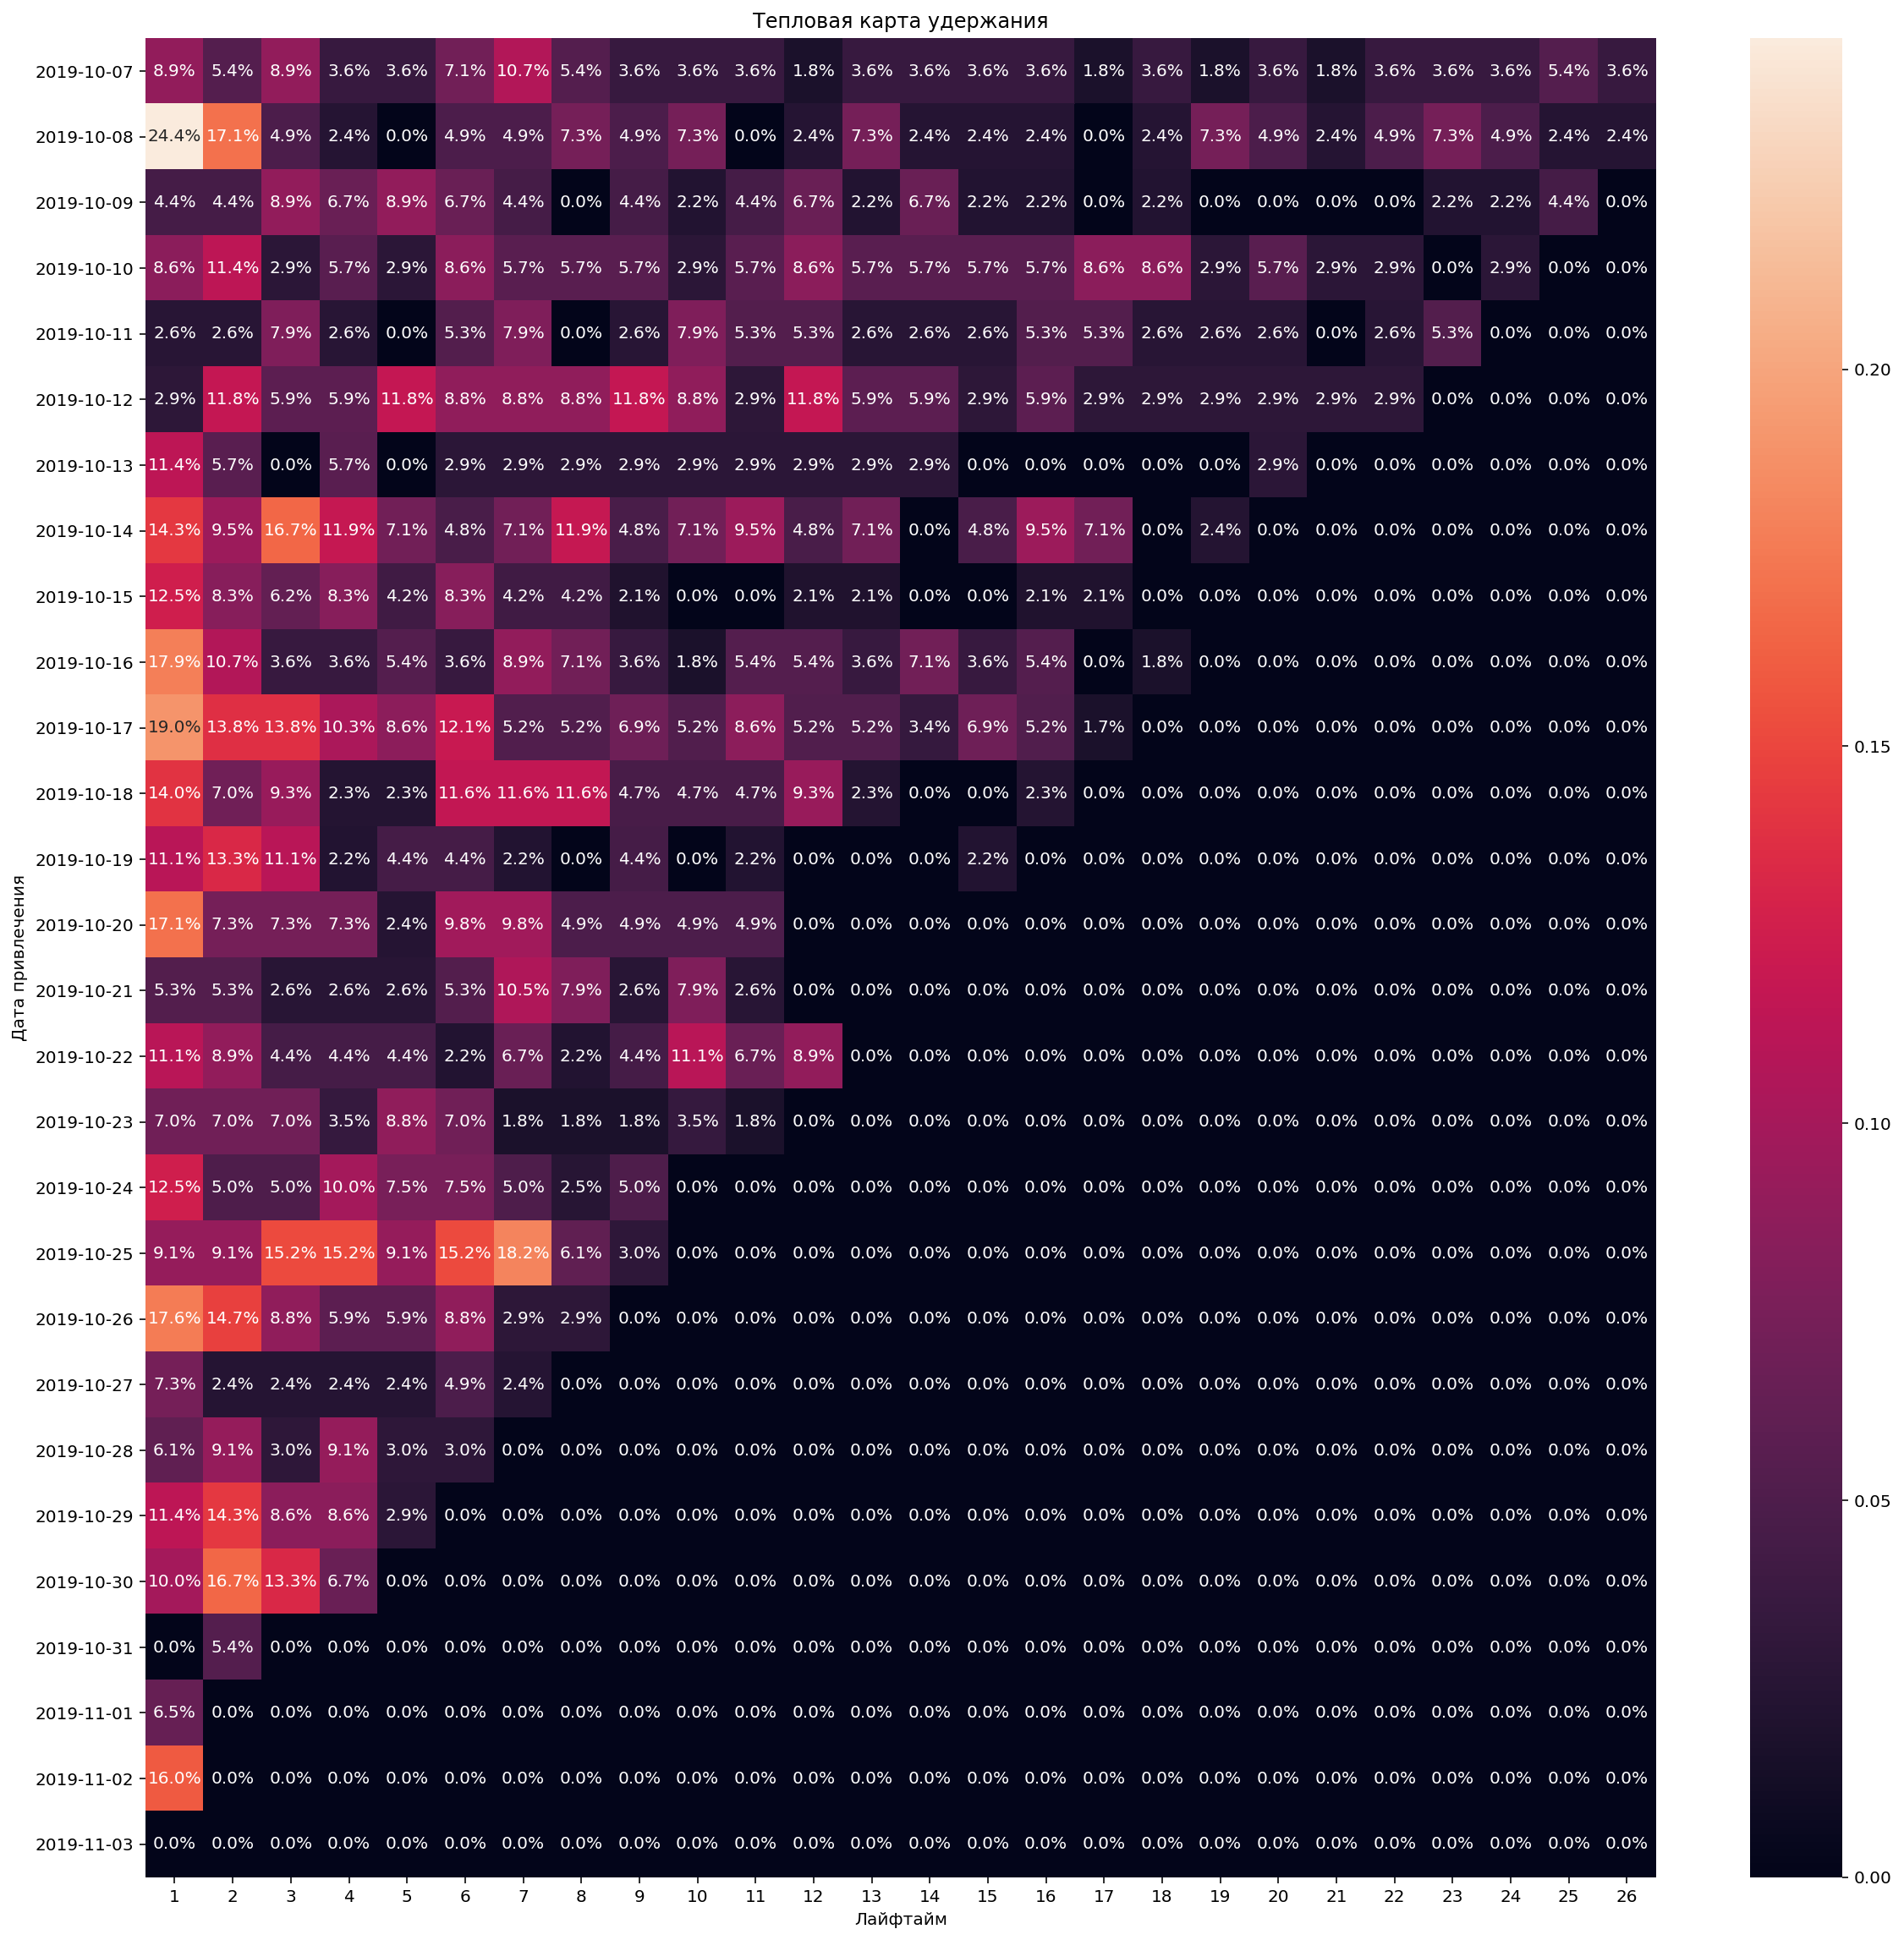

In [36]:
# Передадим функции retention() таблицу с данными о пользователях, загрузивших приложение через Гугл
retention(google)

Несколько хуже, чем у Яндекса, удержание пользователей, привлеченных через Гугл, несмотря на то, что в первые два дня использования приложения удержание в некоторых случаях достигает значений от 19 до 28 % (выше, чем Яндекса). В первый и последующие дни использования приложения процент удержания пользователей, привлеченных через Гугл в диапазоне от 0 до 3 % встречается значительно чаще, чем загрузивших приложение через Яндекс.

In [37]:
# Выделим данные с пользователями, загрузившими приложение через Другие источники
others = data.loc[data['source'] == 'other']
# Получим профили пользователей, загрузивших приложение через Другие источники
profiles = get_profiles(others)

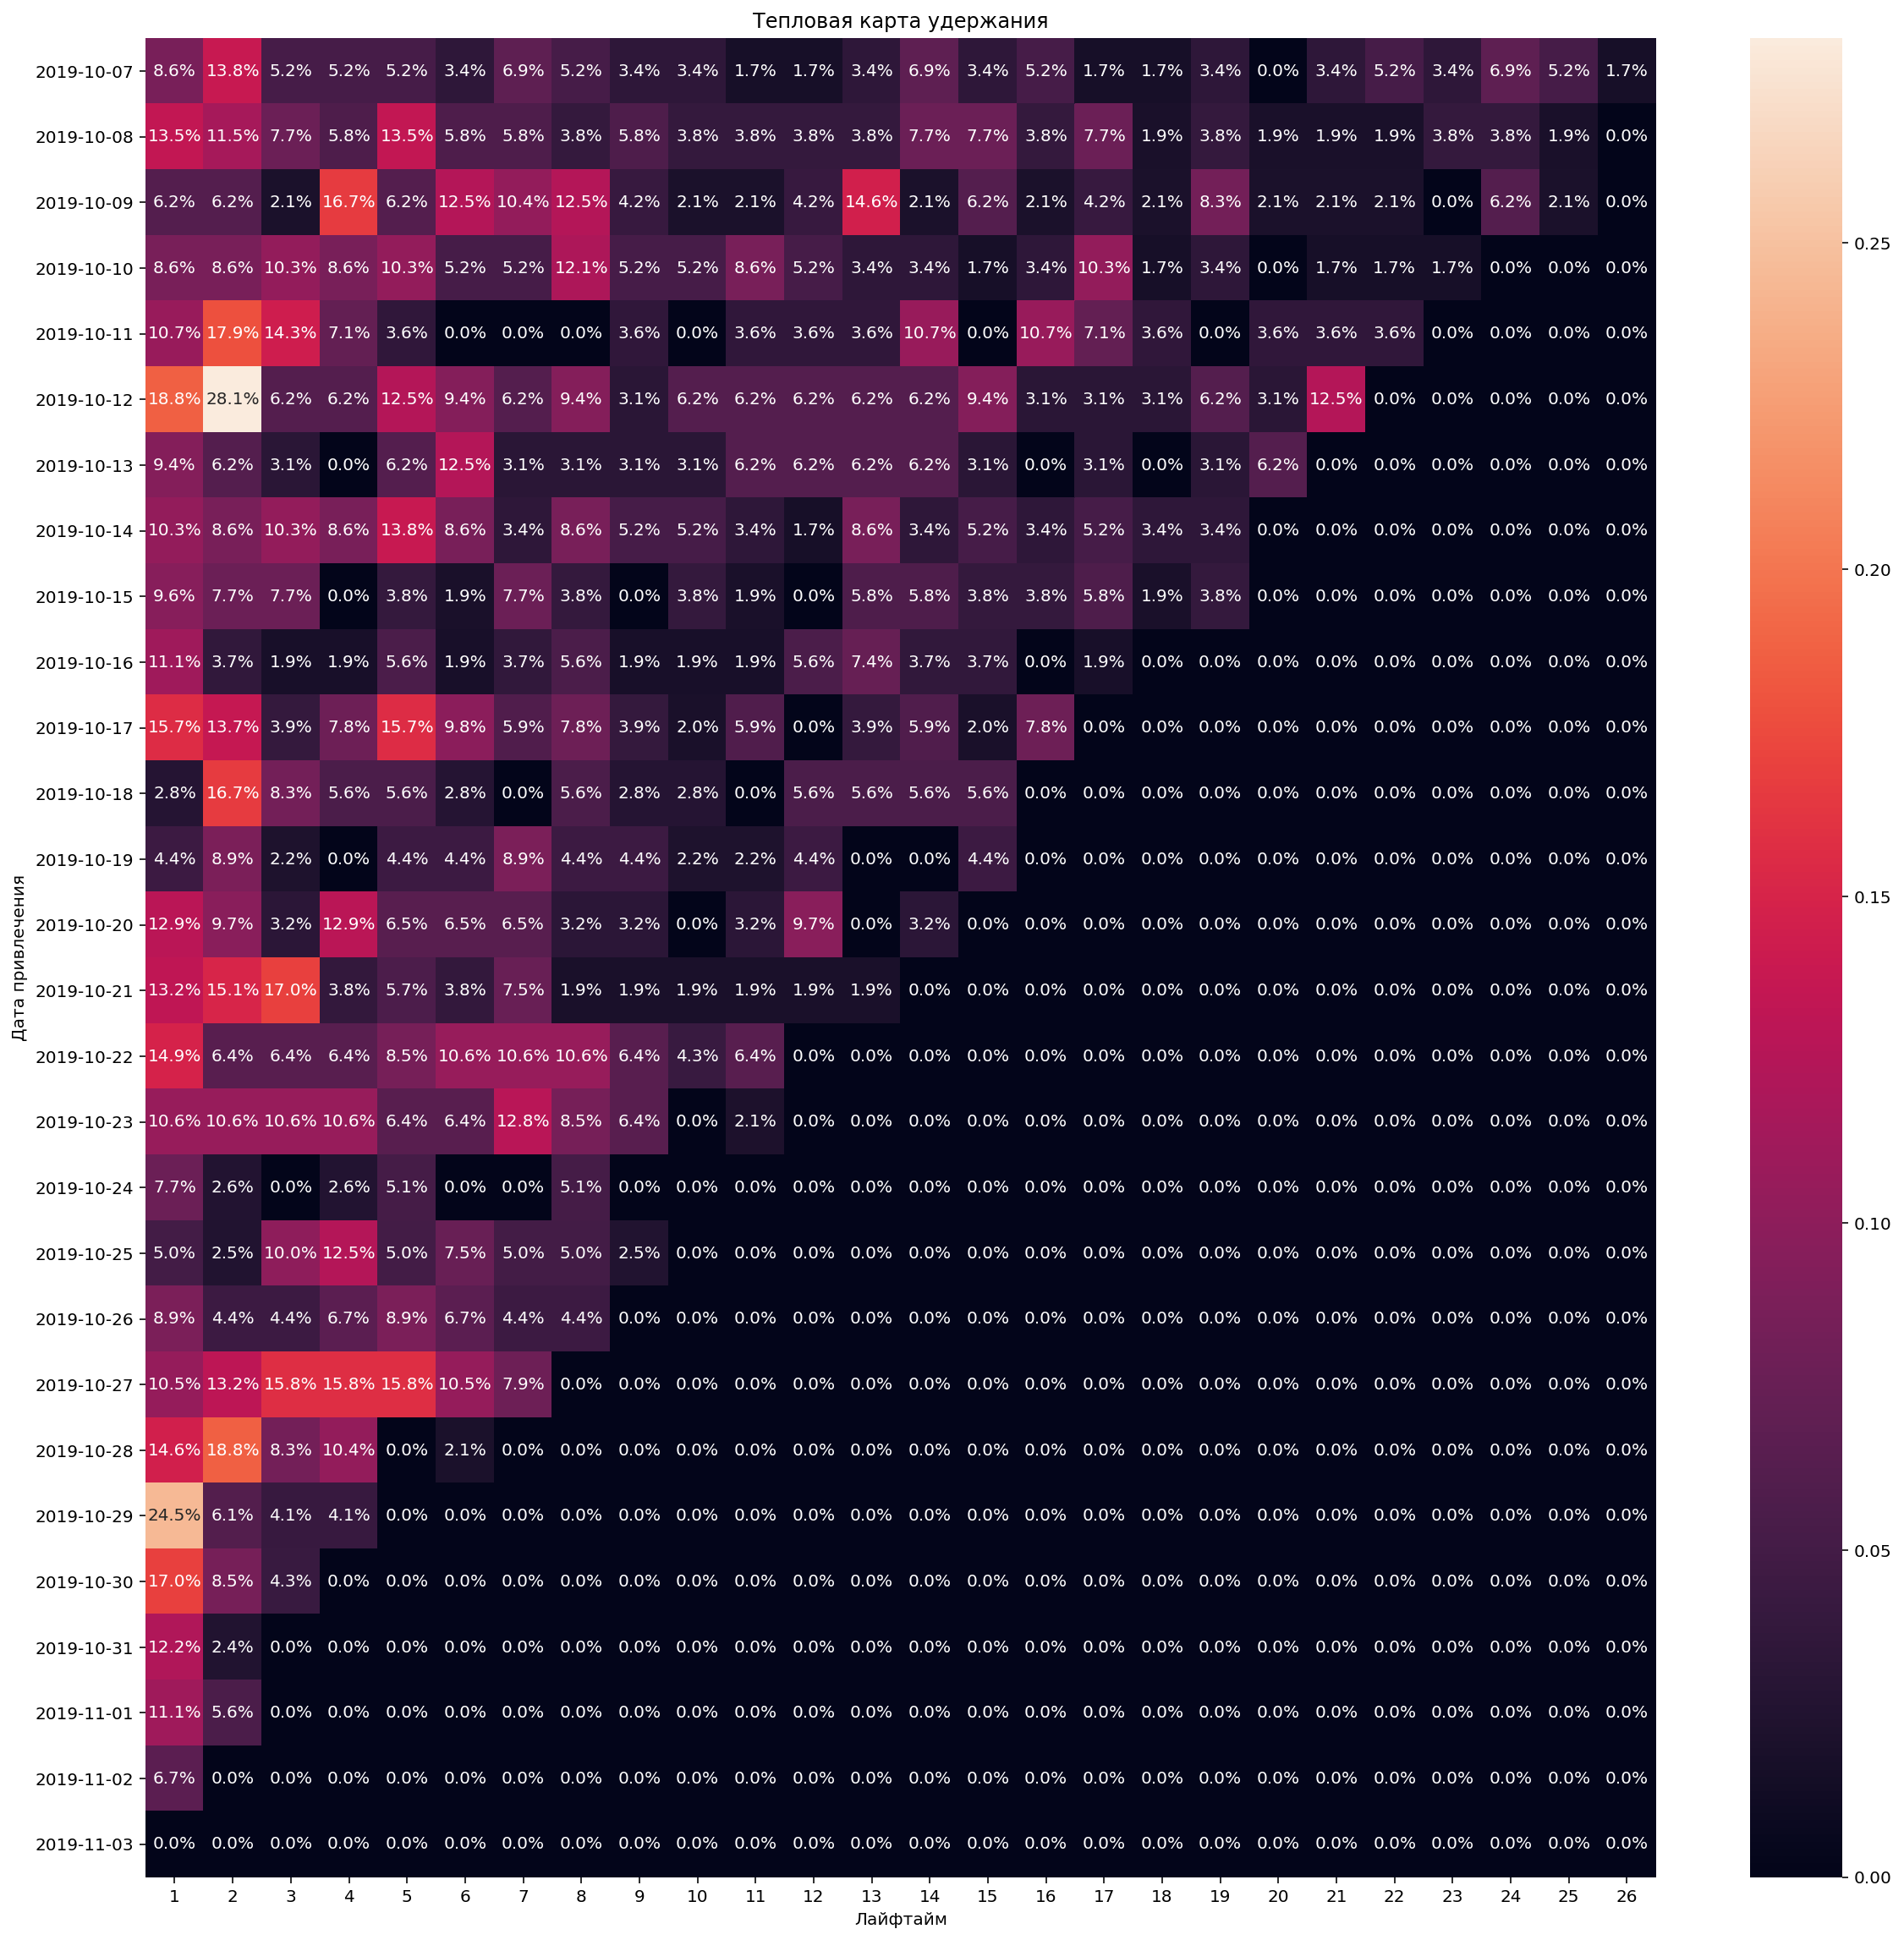

In [38]:
# Передадим функции retention() таблицу с данными о пользователях, загрузивших приложение через Другие источники
retention(others)

Подобная пользователям, привлеченным через Гугл, картина наблюдается и в удержании пользователей, загрузивших приложение через Другие источники. Другие источники привлечения хоть и демонстрируют достаточно неплохое удержание в первые дни использования приложения, как и Гугл, но чаще теряют пользователей, чем Яндекс, в последующие лайфтаймы.  

Таким образом, можно сказать, что наиболее перспективный с точки зрения  удержания пользователей в мобильном приложении канал  - Яндекс. Пользователи, загрузившие приложение через этот канал, покидают приложение реже, чем через другие каналы.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

Да, результаты получились интересными
</div>

### Определим, пользователи какой группы склонны чаще делать целевое действие (конверсия в просмотры контактов)

In [39]:
print('Конверсия в просмотры контактов (yandex), %:', round(yandex.loc[yandex['event_name'] == 'contacts_show']['user_id']
                                                            .nunique()*100 / yandex['user_id'].nunique()))
print()
print('Конверсия в просмотры контактов (google), %:', round(google.loc[google['event_name'] == 'contacts_show']['user_id']
                                                            .nunique()*100 / google['user_id'].nunique()))
print()
print('Конверсия в просмотры контактов (other), %:', round(others.loc[others['event_name'] == 'contacts_show']['user_id']
                                                           .nunique()*100 / others['user_id'].nunique()))

Конверсия в просмотры контактов (yandex), %: 25

Конверсия в просмотры контактов (google), %: 24

Конверсия в просмотры контактов (other), %: 19


Конверсия пользователей в целевое действие - просмотр номера телефона, привлеченных через Яндекс и Гугл достаточно близка (у Яндекса на 1 % выше), а через другие источники значительно ниже - менее 20 %.

Выводы к разделу 3:

- Пользователи были разделены на 3 группы по источнику установки мобильного приложения: Яндекс, Гугл и Другие источники. Больше всего пользователей было привлечено через Яндекс (1934), а меньше всего - через Гугл (1129).
- Удержание пользователей, загрузивших приложение через Яндекс, выше, чем через Гугл и Другие источники (особенно в течение первой недели использования приложения).
- Конверсия пользователей в просмотр номера телефона, привлеченных через Яндекс, равна 25 %, всего  на 1 % выше, чем привлеченных через Гугл, и на 6 % выше, чем привлеченных через Другие источники.
- На основании выводов выше, среди источников, с которых пользователи устанавливают приложение, можно выделить целевую группу, на привлечение которой можно было бы тратить больше рекламных денег – это пользователи, загружающие приложение через Яндекс, и смежную группу – пользователей Гугла, расходы на рекламу приложения среди которых, как минимум, не стоило бы снижать.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

Отлично проведенный этап. На все вопросы получены ответы. Результаты логичные, было бы странным увидеть значительную разницу между пользователями из разных источников привлечения
</div>

## Проверим статистические гипотезы

### Проверим гипотезу: имеется ли статистическая значимость  различий в конверсии в просмотры контактов между пользователями, которые установили приложение по ссылке из yandex и из google

Сформируем гипотезы:
- Нулевая гипотеза: статистически значимых различий в конверсиях в просмотры контактов между пользователями, установившими приложение по ссылке из Яндекс и из Гугла, нет
- Альтернативная гипотеза: статистически значимые различия различия в конверсиях в просмотры контактов между пользователями, установившими приложение по ссылке из Яндекс и из Гугла, есть

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

Верная интерпритация нулевой и альтернативной гипотез
</div>

Для проверки гипотез, сравнения долей порльзователей, будем использовать z-тест.

In [40]:
# Расcчитаем общее количество пользователей, установивших приложение по ссылке из Яндекса и из Гугла:
cnt_yan_all = yandex['user_id'].nunique()
cnt_goo_all = google['user_id'].nunique()

In [41]:
# Расcчитаем количество пользователей, посмотревших контакты, в каждой из этих групп:
cnt_yan = yandex.loc[yandex['event_name'] == 'contacts_show']['user_id'].nunique()
cnt_goo = google.loc[google['event_name'] == 'contacts_show']['user_id'].nunique()

In [42]:
# Установим статистической значимости (alpha) равным 0.05
alpha = 0.05
# Посчитаем, сколько всего уникальных пользователей в датафреймах: 
users_all = np.array([cnt_yan_all, cnt_goo_all])
# и сколько из них совершило событие:
users_part = np.array([cnt_yan, cnt_goo])

# доля пользователей, совершивших событие, в первой группе:
p1 = users_part[0]/users_all[0]

# доля пользователей, совершивших событие, во второй группе:
p2 = users_part[1]/users_all[1]

# доля пользователей, совершивших событие, в комбинированном датасете:
p_combined = (users_part[0] + users_part[1]) / (users_all[0] + users_all[1])

# разница долей пользователей, совершивших действие в датасетах: 
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения:
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_all[0] + 1/users_all[1]))
    
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

# находим p-value
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('Количество пользователей, загрузивших приложение через ссылку в Яндексе:', cnt_yan_all)
print('Количество пользователей, просмотревших контакты (установка приложения из Яндекса):', cnt_yan)
print('Количество пользователей, загрузивших приложение через ссылку в Гугле:', cnt_goo_all)
print('Количество пользователей, просмотревших контакты (установка приложения из Гугла):', cnt_goo)
print('Разница конверсий пользователей в просмотр контактов между группами:', round(difference, 3))
print('Значение p_value:', round(p_value, 3))

# Делаем вывод на основании полученного значения p_value:
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между конверсиями в просмотр контактов есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в просмотр контактов разными')

Количество пользователей, загрузивших приложение через ссылку в Яндексе: 1934
Количество пользователей, просмотревших контакты (установка приложения из Яндекса): 478
Количество пользователей, загрузивших приложение через ссылку в Гугле: 1129
Количество пользователей, просмотревших контакты (установка приложения из Гугла): 275
Разница конверсий пользователей в просмотр контактов между группами: 0.004
Значение p_value: 0.824
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в просмотр контактов разными


Таким образом, статистически значимых различий в конверсиях в просмотры контактов между пользователями, установившими приложение по ссылке из Яндекс и из Гугла, нет. Конверсии пользователей в просмотр контактов, привлеченных через Яндекс и Гугл, отличаются не более, чем на 1 %.

### Проверим гипотезу: имеется ли статистическая значимость различий в конверсии в просмотры контактов между пользователями, кликнувшими по рекомендованным объявлениям (tips_click) и выполнившими поиск по сайту (search) 

Сформируем гипотезы:
- Нулевая гипотеза: статистически значимых различий в конверсиях в просмотры контактов между пользователями, кликнувших по рекомендованным объявлениям и выполнившими поиск по сайту самостоятельно, нет
- Альтернативная гипотеза: статистически значимые различия в конверсиях в просмотры контактов между пользователями, кликнувших по рекомендованным объявлениям и выполнившими поиск по сайту самостоятельно, есть

Для проверки данных гипотез также будем использовать z-тест.

In [43]:
# Создадим списки с уникальными пользователями, кликнувших по рекомендованному объявлению и выполнивших поиск по сайту:
cnt_t_list = data.loc[data['event_name'] == 'tips_click']['user_id'].unique()
cnt_s_list = data.loc[data['event_name'] == 'search']['user_id'].unique()

# Расcчитаем общее количество пользователей, кликнувших по рекомендованному объявлению и выполнивших поиск по сайту:
cnt_t_all = data.loc[data['event_name'] == 'tips_click']['user_id'].nunique()
cnt_s_all = data.loc[data['event_name'] == 'search']['user_id'].nunique()


In [44]:
# Создадим два датафрейма: в первом отфильтруем исходный датафрейм data по уникальным пользователям, кликнувшим по рекомендованным 
# объявлениям (tips_click), а во втором - выполнившим самостоятельный поиск (search) 
tips_click = data.query('user_id in @cnt_t_list')
search = data.query('user_id in @cnt_s_list')

In [45]:
# Расcчитаем количество пользователей, посмотревших контакты, в каждой из получившихся групп:
cnt_t = tips_click.loc[tips_click['event_name'] == 'contacts_show']['user_id'].nunique()
cnt_s = search.loc[search['event_name'] == 'contacts_show']['user_id'].nunique()


In [46]:
# Установим статистической значимости (alpha) равным 0.05
alpha = 0.05
# Посчитаем, сколько всего уникальных пользователей в датафреймах: 
users_all = np.array([cnt_t_all, cnt_s_all])
# и сколько из них совершило событие:
users_part = np.array([cnt_t, cnt_s])

# доля пользователей, совершивших событие, в первой группе:
p1 = users_part[0]/users_all[0]

# доля пользователей, совершивших событие, во второй группе:
p2 = users_part[1]/users_all[1]

# доля пользователей, совершивших событие, в комбинированном датасете:
p_combined = (users_part[0] + users_part[1]) / (users_all[0] + users_all[1])

# разница долей пользователей, совершивших действие в датасетах: 
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения:
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_all[0] + 1/users_all[1]))
    
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

# находим p-value
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('Количество пользователей, кликнувших по рекомендованному объявлению:', cnt_t_all)
print('Количество пользователей, кликнувших по рекомендованному объявлению и просмотревших контакты:', cnt_t)
print('Количество пользователей, выполнивших поиск по сайту:', cnt_s_all)
print('Количество пользователей, выполнивших поиск по сайту и просмотревших контакты:', cnt_s)
print('Разница конверсий пользователей в просмотр контактов между группами:', round(difference, 3))
print('Значение p_value:', round(p_value, 3))

# Делаем вывод на основании полученного значения p_value:
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между конверсиями в просмотр контактов есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в просмотр контактов разными')

Количество пользователей, кликнувших по рекомендованному объявлению: 322
Количество пользователей, кликнувших по рекомендованному объявлению и просмотревших контакты: 100
Количество пользователей, выполнивших поиск по сайту: 1666
Количество пользователей, выполнивших поиск по сайту и просмотревших контакты: 377
Разница конверсий пользователей в просмотр контактов между группами: 0.084
Значение p_value: 0.001
Отвергаем нулевую гипотезу: между конверсиями в просмотр контактов есть значимая разница


Как видно из проведенного теста, статистически значимые различия в конверсиях в просмотры контактов между пользователями, кликнувших по рекомендованным объявлениям и выполнившими поиск по сайту самостоятельно, есть. Конверсия пользователей в контакты, кликнувших на рекомендованные объявления на 8,4 % выше, пользователей, выполнивших поиск по сайту.

Вывод к разделу 4: 
- Есть статистически значимая разница в конверсиях в просмотры контактов между пользователями, кликнувшими по рекомендованным объявлениям и выполнившими поиск по сайту самостоятельно. Конверсия пользователей, кликнувших по рекомендованным объявлениям выше на 8,4 % и равна 31 %;
- Нет статистически значимой разницы в конверсиях в просмотры контактов между пользователями, установившими приложение по ссылке из Яндекс и из Гугла. Конверсия пользователей из этих групп практически одинакова.


<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

Методологически проверка гипотез проведена верно и наглядный вывод результатов. Так держать!
</div>

## Общий вывод

- Исходные данные проверены на наличие пропусков и дубликатов, обработаны обнаруженные неявные дубликаты в колонке с названием события, названия колонок всех таблиц приведены к нижнему и «змеиному» регистрам, тип данных в столбцах с датой переведен в формат datetime, создана функция для получения профилей пользователей, оценена полнота данных за рассматриваемый период, создана функция для расчета удержания пользователей и построения тепловой карты, выделены сессии пользователей относительно тайм-аута, произведена сегментация пользователей по источнику привлечения, проверены 2 статистические гипотезы о различиях в конверсии;
- Данные за исследуемый период с 7 октября по 3 ноября 2019 года достаточно полные. Лучший процент удержания пользователей наблюдается в первые дни использования приложения (до 17 %). С увеличением лайфтайма в целом процент снижается, однако наблюдаются и его скачки, связанные с возвращением пользователей в приложение спустя несколько дней. На основе аналитических данных Adjust по средней продолжительности сессии пользователей мобильных приложений за 2019 год (10-11 мин), выбран тай-аут в 20 мин, относительно которого и были выделены сессии в рассматриваемых данных. Однако, в связи с наличием в данных выбросов, принято решение временем, проведенным пользователем в приложении, считать медианное значение продолжительности сессии – 4 мин 55 сек.
- Чаще всего пользователи видели рекомендованные объявления (не менее 40000 раз) и просматривали фотографии в объявлении (не менее 10000). Реже всего набирали номер, указанный в карточке объявления (541). Чаще других дней недели пользователи совершают события в понедельники. В течение недели с понедельника по субботу частота совершения событий снижается и достигает своего минимума в субботу, а с воскресенья снова резко возрастает. Снижение пользовательской активности при приближении к выходным дням связано с нежеланием большинства пользователей проводить сделки и забирать купленные ими вещи в выходные дни, а резкий рост пользовательской активности в воскресенье, по всей видимости, связан с подготовкой к проведению сделок на рабочей неделе.
- Всего в исследуемых данных 4293 уникальных пользователя. Конверсия в целевое действие - просмотры контактов от общего числа пользователей составляет 23 %. Наибольшая конверсия пользователей (65 %) в просмотр рекомендованных объявлений, а наименьшая – в звонок по номеру телефона в карточке объявления (5 %).
- Выполнена сегментация пользователей по источнику привлечения: Яндекс (1934 пользователя), Гугл (1230) и Другие источники (1129). Лучше всего в первые дни использования приложения удерживаются пользователи, привлеченные через Яндекс. Конверсия пользователей в просмотр контактов, загрузивших приложение через ссылку на Яндексе и Гугле практически одинакова, 25 и 24 % соответственно, а на Других источниках ниже (19 %). На основании этого предлагается выделить пользователей, привлеченных посредством Яндекса, в целевую группу, на привлечение которой можно тратить больше рекламных денег, а Гугла - в смежную группу, траты на рекламу среди которых не стоило бы уменьшать. Траты на привлечение пользователей из Других источников при этом можно было бы снизить.
- Статистически значимых различий в конверсии в просмотры контактов между пользователями, которые установили приложение по ссылке из Яндекс и из Гугл, нет (разница между конверсиями не превышает 1 %), а между пользователями, кликнувшими по рекомендованным объявлениям и выполнившими поиск по сайту, есть (конверсия пользователей, кликнувших по рекомендованным объявлениям, равная 31 %, на 8,4 % выше).
- При последующем сборе исходных данных инженерам рекомендуется уделять особое внимание неявным дубликатам в колонке с названиями событий, которые выполняют пользователи. Маркетологам рекомендуется привлекать больше пользователей через каналы Яндекс (в первую очередь) и Гугл. 

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

Итоговый вывод завершает твое исследование. Представлены основные результаты полученные в ходе анализа, но самое главное - даны рекомендации по  развитию приложения. Это важное качество для аналитика. Развивай его и дальше

</div>

<div class="alert alert-block alert-warning">📝
Комментарий от тимлида №1 </b> 



Итог ревью - ты проделала хорошую работу! Все расчеты корректные, грамотная интерпретация полученных результатов! У тебя есть понимание данного процесса. Но есть некоторые моменты которые тебе предстоит доработать, чтобы я смог принять твой проект. Если возникнут вопросы - обязательно задавай. Буду ждать!

Зы. На следующую итерацию присылай презентацию, но перед этим лучше покажи её в пачке

---

Нужно поправить:

1) Оформление графиков

----


Если у тебя будут какие-то вопросы по моим комментариям - обязательно пиши! Буду ждать работу на повторное ревью :)</div>

<div class="alert alert-info"> <b>Комментарии студента:</b> Все поправил и добавил ссылку на презентацию </div>

## Презентация 

https://disk.yandex.ru/i/OWy-YlT_-4kiDw


<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №2__

Хорошая презентация как по содержанию так и по структуре. Все важные моменты исследования представлены. Используешь тезисный подход и не злоупотребляешь текстом на слайдах.
    
---
    
У Яндекс Практикума есть отличный и бесплатный курс по презентациям. Советую, в свободное время освоить его (https://practicum.yandex.ru/profile/visual-presentation/)    

</div>

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №2__

От себя хочу порекомендовать тебе отличную книгу про язык Python. Она очень классная (можно купить как новую, так и на Авито попадается. Вот ссылка на pdf этой книги)
    
https://monster-book.com/avtomatizaciya-zadach-s-python
    
---
    


Все замечания учтены. Успехов на АВ тесте!
</div>